In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install timm

In [2]:
import sys
sys.path.append('/vol/Data/petfinder-pawpularity-score')
### <디렉토리 설정하는 곳> (검색용) ################################################################################################
### 지금 위의 코드는
### 이 코드파일(ai_final_loss_plot.ipynb)과 함께 다른 데이터셋 관련파일들(test, train, sample_submission.csv, test.csv, train.csv)을 
### 구글드라이브 안의 /ai/final/petfinder-pawpularity-score 디렉토리에 넣어줘야, 코드가 돌아가도록 되어있다.
###
### 위에서 말한 코드파일과 데이터셋 관련 파일들의 위치를 바꾸고 싶으면, 
### 위의 sys.path.append() 안의 인자를 'drive/MyDrive/(구글 드라이브 내의 디렉토리 주소)' 로 바꿔주면 된다.
####################################################################################################################################

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

import cv2
from os import path
from PIL import Image
import torch.utils.data as data
from torchvision import models, transforms
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import h5py
import timm
import shutil

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

In [4]:
class args:
### <배치크기, 에폭수 설정하는 곳 (검색용)> ######################
### 지금은 batch_size 값 32, 에폭수 10으로 되어있다. 
##################################################################

    seed = 22
    batch_size = 32
    epochs = 20
    image_size = 384  # scale shorter end of image to this size and centre crop
    central_fraction = 0.875  # only take this much of the centre when scaling and centre cropping
    load_img = False # whether load img or not
    workers = 2
    feature_extract = True

def seed_torch(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print("seed: ", seed)

seed_torch(args.seed)

seed:  22


In [5]:
def makedirs(path): 
  if os.path.exists(path):
    shutil.rmtree(path)
  try: 
    os.makedirs(path) 
  except OSError: 
    if not os.path.isdir(path): 
      raise

In [6]:
dir_path = '/vol/Data/petfinder-pawpularity-score'
### <디렉토리 설정하는 곳> (검색용) ################################################################################################
### 지금 위의 코드는
### 이 코드파일(ai_final_loss_plot.ipynb)과 함께 다른 데이터셋 관련파일들(test, train, sample_submission.csv, test.csv, train.csv)을 
### 구글드라이브 안의 /ai/final/petfinder-pawpularity-score 디렉토리에 넣어줘야, 코드가 돌아가도록 되어있다.
###
### 위에서 말한 코드파일과 데이터셋 관련 파일들의 위치를 바꾸고 싶으면, 
### 위의 sys.path.append() 안의 인자를 'drive/MyDrive/(구글 드라이브 내의 디렉토리 주소)' 로 바꿔주면 된다.
####################################################################################################################################

cached_dir = path.join(dir_path, 'cached_data')
train_img_dir = path.join(dir_path, 'train')
test_img_dir = path.join(dir_path, 'test')
aug_img_dir = path.join(dir_path, 'train_aug')

df_train = pd.read_csv(path.join(dir_path, 'train.csv'))
df_test = pd.read_csv(path.join(dir_path, 'test.csv'))

train_img_paths = [path.join(train_img_dir, f"{img_id}.jpg") for img_id in df_train["Id"].values]
test_img_paths = [path.join(test_img_dir, f"{img_id}.jpg") for img_id in df_test["Id"].values]

# 경로에 파일 없으면 생성 있으면 지우고 재생성 
makedirs(aug_img_dir)

In [7]:
property_names = [col for col in df_train.columns if col not in ['Id','Pawpularity']]
property_names # 12 properties

# train metda data
train_meta_X = df_train[property_names]
train_Y = df_train['Pawpularity']

# test metda data
test_id = df_test['Id']
test_meta_X = df_test.drop('Id',axis=1)
test_meta_X.shape

(8, 12)

In [8]:
class PawpularDataset(data.Dataset):
    def __init__(self, image_data, meta_features, labels, img_paths, augmentations=None):
        super(PawpularDataset, self).__init__()
        self.load_img = False
        self.image_data = image_data
        self.meta_features = meta_features
        self.labels = labels
        self.augmentations = augmentations
        self.image_paths = img_paths
        if self.augmentations is not None:
            self.load_img = True


    def __getitem__(self, item):
        if self.load_img:
            image = cv2.imread(self.image_paths[item])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            augmented = self.augmentations(image=image)["image"]
            
            #augmentation 저장
            #save_aug(augmented,item)

            image = np.transpose(augmented, (2, 0, 1)).astype(np.float32)
        else:
            image = self.image_data[item]

        meta = self.meta_features[item]
        label = self.labels[item]
        return image.astype('float32'), meta.astype('float32'), label

    def __len__(self):
        return len(self.labels)

def save_aug(image, item):
    global aug_img_dir
    """
    Function to Plot the Transformed Images
    """
    #print(label)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    path = aug_img_dir+ "/" +str(item)+".jpg" 
    # print(path)
    cv2.imwrite(path, image)
    #Unnormalize
    # plt.imshow(image)
    # plt.show()

def get_loader(split, features, meta_data, labels, img_paths=[], batch_size=args.batch_size, augmentations=None):
    """ Returns a data loader for the desired split """
    dataset = PawpularDataset(features, meta_data, labels, img_paths, augmentations)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True if split != 'test' else False,  # only shuffle the data in training
        pin_memory=True,
        num_workers=args.workers,
    )
    return loader

In [9]:
import albumentations

def get_augmentations(train=True):
    if train:
        return albumentations.Compose(
            [
                ## 크기조절
                albumentations.Resize(args.image_size, args.image_size, p=1),
                ## 좌우 반전
                albumentations.HorizontalFlip(p=0.5),
                ## 상하 반전
                ##albumentations.VerticalFlip(p=0.5),
                ## 회전
                albumentations.Rotate(limit=45, p=0.7),
            ]
        )
    else:
        return albumentations.Compose(
            [
                albumentations.Resize(args.image_size, args.image_size, p=1),
#                 albumentations.Normalize(
#                     mean=[0.485, 0.456, 0.406],
#                     std=[0.229, 0.224, 0.225],
#                     max_pixel_value=255.0,
#                     p=1.0,
#                 ),
            ]
        )

augmentations = get_augmentations(train=True)#train 데이터(원본)
trainval_loader = get_loader('trainval', None, train_meta_X.values, train_Y.values.astype('float32'), train_img_paths,augmentations=augmentations)

augmentations = get_augmentations(train=False)#train 데이터(데이터증강)
trainval_loader2 = get_loader('trainval', None, train_meta_X.values, train_Y.values.astype('float32'), train_img_paths,augmentations=augmentations)

augmentations = get_augmentations(train=False)#test 데이터
test_loader = get_loader('test', None, test_meta_X.values, torch.zeros(len(test_img_paths)), test_img_paths, augmentations=augmentations)

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### <인공지능 모델 아키텍처 설정하는 곳> (검색용) ################################################################################################
### 아래에는 다음과 같은 모델 아키텍처를 정의하는 class 코드가 있음.
### 
### PretrainedCNN         - 이미 학습되어있는 "resnet" 모델을 불러오고, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### BaseCNN               - CNN 을 활용한 모델, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### BaseMLP               - MLP 를 활용한 모델, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### PretrainedTransformer - 이미 학습되어있는 다양한 모델들 중 하나를 불러오고, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
###
### 이 아래에 class 중에서 직접 수정해보면 좋은 것은, BaseCNN , BaseMLP class 부분임.
### BaseCNN 은 CNN 실습했을때처럼 수정하면 될 듯
### BaseMLP 는 MLP 실습했을때처럼 수정하면 될 듯
###
### 한편, PretrainedTransformer class 를 활용해도 좋음. 이미 학습되어있는 모델을 불러와서 코드를 돌려볼 수 있음. 자세한 내용은 아래 <모델 고르기> 부분에서 설명함.
####################################################################################################################################



class PretrainedCNN(nn.Module):
    def __init__(self, model_name='resnet', use_meta=False):
        super(PretrainedCNN, self).__init__()
        if model_name == 'resnet':
            self.model = models.resnet152(pretrained=True)
            set_parameter_requires_grad(self.model, feature_extracting=True)
            num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 128)
        self.drop = nn.Dropout(0.5)
        self.use_meta =use_meta
        if self.use_meta:
            self.fc = nn.Linear(128+12, 1)
        else:
            self.fc = nn.Linear(128, 1)
        

    def forward(self, img_data, meta=None, targets=None):
        x = self.model(img_data)
        if self.use_meta:
            x = torch.cat([x, meta], dim=1)
        x = self.fc(self.drop(x)) # [b, o]
        return x



class BaseCNN(nn.Module):
    def __init__(self, num_filters=[], use_meta=False):
        super(BaseCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, num_filters[0], kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(num_filters[0], num_filters[1], kernel_size = 4, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(num_filters[1], num_filters[2], kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(num_filters[2] ,num_filters[3], kernel_size = 8, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(num_filters[3], num_filters[4], kernel_size = 6, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(num_filters[4], num_filters[4], kernel_size = 6, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(12544, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,128)
        )
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        if self.use_meta:
            self.fc = nn.Linear(128+12, 1)
        else:
            self.fc = nn.Linear(128, 1)


    def forward(self, img_data, meta=None, targets=None):
        o = self.conv(self.drop(img_data)) # [b, 1, m]
        if self.use_meta:
            o = torch.cat([o, meta], dim=1)
        x = self.fc(self.drop(o)) # [b, o]
        return x


class BaseMLP(nn.Module):
    def __init__(self, use_meta=False, input_size=args.image_size):
        super(BaseMLP, self).__init__()
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        self.lin = nn.Sequential(
            nn.Linear(input_size*input_size, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Dropout(0.5),
            nn.Linear(512,128)
        )
        if self.use_meta:
            self.fc = nn.Linear((128*3)+12, 1)
        else:
            self.fc = nn.Linear(128*3, 1)


    def forward(self, img_data, meta=None, targets=None):
        b, c, img_size, _ = img_data.shape
        img_data = img_data.view(b, c, img_size*img_size)
        o = self.lin(self.drop(img_data)) # [b, 3, 128]
        o = o.view(b, -1)
        if self.use_meta:
            o = torch.cat([o, meta], dim=1)
        x = self.fc(self.drop(o)) # [b, o]
        return x


class PretrainedTransformer(nn.Module):
    def __init__(self, model_name='', use_meta=False, pretrained=True):
        super(PretrainedTransformer, self).__init__()
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        set_parameter_requires_grad(self.model, feature_extracting=True)
        num_features = self.model.num_features

        if self.use_meta:
            self.fc = nn.Linear(num_features+12, 1)
        else:
            self.fc = nn.Linear(num_features, 1)


    def forward(self, img_data, meta=None, targets=None):
        x = self.model(img_data)
        if self.use_meta:
            x = torch.cat([x, meta], dim=1)
        x = self.fc(self.drop(x)) # [b, o]
        return x




torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [11]:
import matplotlib.pyplot as plt 
test_loss_record = [] 
mse = nn.MSELoss()  


def train(model, optimizer, train_loader, val_loader, train=True, val=False, epoch=0, grad_clip=False):
    labels, preds = [], []
    if train:
        train_loader = tqdm(train_loader, desc='{} E{:03d}'.format('train', epoch), ncols=0)
        model.train()
        for i, (img, meta_feature, label) in enumerate(train_loader):
            img = img.cuda().float()
            meta_feature = meta_feature.cuda()
            label = label.cuda()
            pred = model(img, meta_feature, label)

            # loss = criterion(pred , label.view(-1,1))
            loss = mse(pred, label.view(-1, 1))

            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            num = 10
            if i % num == 0:
                rmse_loss = pow(loss.item() , 0.5)
                print("\tTrain Epoch:{} \tTrain Loss(RMSE): {:.6f}".format(epoch, rmse_loss)) ##
                test_loss_record.append(rmse_loss)
    
    if val:
        model.eval()
        val_loader = tqdm(val_loader, desc='{} E{:03d}'.format('val', epoch), ncols=0)
        for i, (img, meta_feature, label) in enumerate(val_loader):
            img = img.cuda().float()
            pred = model(img, meta_feature, None)

            labels.append(label.detach().cpu())
            preds.append(pred.detach().cpu())

        labels = torch.cat(labels, dim=0).numpy() # [num_seg]
        preds = torch.cat(preds, dim=0).numpy() # [num_seg]

    return labels, preds

In [12]:
### <학습된 모델 확인하기> (검색용) ######################
### 사용할 수 있는 이미 학습된 모델들을 아래 출력해줌
##########################################################
timm.list_models()[:]

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

In [13]:
import torch.optim as optim

name = 'tf_efficientnet_b0_ns'

### <모델 고르기> (검색용) ##########################################################################################################
### 학습에 사용할 인공지능 모델을 골라준다.
### 아래 주석을 해제하여 사용
### 
### PretrainedTransformer 사용하는 방법
### 1. 아래 "model = PretrainedTransformer.." 가 있는 줄의 주석을 해제한다.
### 2. 아까 위에서 <학습된 모델 확인하기>에서 출력된 모델 중 하나를 고른다.
### 3. 아래 (학습된 모델 이름) 에 넣어준다.
#####################################################################################################################################
#model = PretrainedCNN(use_meta = True)                                          ### PretrainedCNN(resnet모델) 을 사용하는 경우
#model = BaseCNN(num_filter = [3,4,5,6,7], use_meta = True)                                                ### BaseCNN 을 사용하는 경우
#model = BaseMLP(use_meta = True)                                                ### BaseMLP 를 사용하는 경우
model = PretrainedTransformer(model_name='seresnet50', use_meta = True) ### PretrainedTransformer 을 사용하는 경우 


params_to_update = model.parameters()
print("Params to learn:")
if args.feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

### <optimizer 설정하는 곳> (검색용) ###############################################################
### 지금은 optim.Adam 으로 설정되어있음. optim.Adam 대신 다른 optimizer 알고리즘으로 바꿀수 있다.
###
### 다른 optimizer들 : optim.Adadelta , optim.Adagrad, optim.AdamW 등등
### 다른 optimizer로 바꾸려면, 해당 optimizer 알고리즘에 필요한 인자들을 알맞게 넣어줘야 한다. 
### 인자를 넣는 형식 등 자세한 사용법은 https://pytorch.org/docs/stable/optim.html 에 가서 
### Algorithms 부분 밑에 알고리즘을 클릭해서 들어가면 알 수 있음.
####################################################################################################
learning_rate = 1e-2
optimizer = optim.Adam(params_to_update, lr=learning_rate, amsgrad=False)
model = nn.DataParallel(model).cuda()

Params to learn:
	 fc.weight
	 fc.bias


In [14]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    #correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += mse(output, label).item()
    
    test_loss /= (len(test_loader.dataset) / args.batch_size)

    return test_loss

In [15]:
# Train & val the model
best_score = 0
epochs = args.epochs



for epoch in range(epochs):
    labels, pred = train(model, optimizer, trainval_loader, None, train=True, val=False, epoch=epoch, grad_clip=True)

    torch.save({"model": model.state_dict()}, "efficient_model.pth")
    
for epoch in range(epochs):
    labels, pred = train(model, optimizer, trainval_loader2, None, train=True, val=False, epoch=epoch, grad_clip=True)

    torch.save({"model": model.state_dict()}, "efficient_model.pth")

train E000:   1% 3/310 [00:02<03:00,  1.70it/s]

	Train Epoch:0 	Train Loss(RMSE): 44.958180


train E000:   4% 11/310 [00:03<01:19,  3.78it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.385154


train E000:   7% 21/310 [00:06<01:25,  3.38it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.260030


train E000:  10% 31/310 [00:09<01:18,  3.57it/s]

	Train Epoch:0 	Train Loss(RMSE): 23.466381


train E000:  13% 41/310 [00:11<01:18,  3.45it/s]

	Train Epoch:0 	Train Loss(RMSE): 22.106384


train E000:  16% 51/310 [00:14<01:13,  3.52it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.278023


train E000:  20% 61/310 [00:16<01:09,  3.57it/s]

	Train Epoch:0 	Train Loss(RMSE): 17.265294


train E000:  23% 71/310 [00:19<01:08,  3.47it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.630851


train E000:  26% 81/310 [00:22<01:07,  3.38it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.546976


train E000:  30% 92/310 [00:25<00:53,  4.05it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.908265


train E000:  33% 101/310 [00:27<00:58,  3.59it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.390808


train E000:  36% 111/310 [00:30<00:55,  3.56it/s]

	Train Epoch:0 	Train Loss(RMSE): 14.700138


train E000:  39% 121/310 [00:32<00:52,  3.58it/s]

	Train Epoch:0 	Train Loss(RMSE): 15.783267


train E000:  42% 131/310 [00:35<00:53,  3.32it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.149430


train E000:  45% 141/310 [00:38<00:55,  3.05it/s]

	Train Epoch:0 	Train Loss(RMSE): 17.242035


train E000:  49% 151/310 [00:41<00:55,  2.87it/s]

	Train Epoch:0 	Train Loss(RMSE): 16.298933


train E000:  52% 161/310 [00:43<00:48,  3.10it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.007521


train E000:  55% 171/310 [00:46<00:47,  2.92it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.596670


train E000:  58% 181/310 [00:49<00:41,  3.13it/s]

	Train Epoch:0 	Train Loss(RMSE): 22.284822


train E000:  62% 191/310 [00:51<00:41,  2.89it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.845114


train E000:  65% 201/310 [00:54<00:37,  2.88it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.419962


train E000:  68% 211/310 [00:57<00:34,  2.90it/s]

	Train Epoch:0 	Train Loss(RMSE): 17.315483


train E000:  71% 221/310 [01:00<00:31,  2.83it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.536925


train E000:  75% 231/310 [01:03<00:27,  2.90it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.617914


train E000:  78% 241/310 [01:05<00:23,  2.94it/s]

	Train Epoch:0 	Train Loss(RMSE): 16.559028


train E000:  81% 251/310 [01:08<00:17,  3.45it/s]

	Train Epoch:0 	Train Loss(RMSE): 24.580708


train E000:  84% 261/310 [01:10<00:15,  3.13it/s]

	Train Epoch:0 	Train Loss(RMSE): 24.999796


train E000:  87% 271/310 [01:13<00:12,  3.13it/s]

	Train Epoch:0 	Train Loss(RMSE): 17.755187


train E000:  91% 281/310 [01:16<00:10,  2.86it/s]

	Train Epoch:0 	Train Loss(RMSE): 17.870926


train E000:  94% 291/310 [01:18<00:06,  3.05it/s]

	Train Epoch:0 	Train Loss(RMSE): 23.064004


train E000:  97% 301/310 [01:21<00:03,  2.88it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.959421


train E000: 100% 310/310 [01:24<00:00,  3.66it/s]
train E001:   0% 1/310 [00:00<05:00,  1.03it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.879850


train E001:   4% 11/310 [00:03<01:38,  3.02it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.627312


train E001:   7% 21/310 [00:06<01:36,  2.98it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.658655


train E001:  10% 31/310 [00:09<01:35,  2.91it/s]

	Train Epoch:1 	Train Loss(RMSE): 23.696926


train E001:  13% 41/310 [00:11<01:23,  3.24it/s]

	Train Epoch:1 	Train Loss(RMSE): 17.843379


train E001:  16% 51/310 [00:14<01:24,  3.07it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.936813


train E001:  20% 61/310 [00:16<01:20,  3.10it/s]

	Train Epoch:1 	Train Loss(RMSE): 23.806139


train E001:  23% 71/310 [00:19<01:21,  2.94it/s]

	Train Epoch:1 	Train Loss(RMSE): 25.602437


train E001:  26% 81/310 [00:22<01:15,  3.02it/s]

	Train Epoch:1 	Train Loss(RMSE): 21.691106


train E001:  29% 91/310 [00:24<01:07,  3.24it/s]

	Train Epoch:1 	Train Loss(RMSE): 22.954318


train E001:  33% 101/310 [00:27<01:04,  3.24it/s]

	Train Epoch:1 	Train Loss(RMSE): 21.533330


train E001:  36% 111/310 [00:30<01:03,  3.15it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.079486


train E001:  39% 121/310 [00:32<00:57,  3.29it/s]

	Train Epoch:1 	Train Loss(RMSE): 21.024069


train E001:  42% 131/310 [00:35<00:55,  3.21it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.670577


train E001:  45% 141/310 [00:37<00:55,  3.04it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.690869


train E001:  49% 151/310 [00:40<00:53,  2.99it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.282000


train E001:  52% 162/310 [00:43<00:38,  3.83it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.809024


train E001:  55% 172/310 [00:46<00:36,  3.77it/s]

	Train Epoch:1 	Train Loss(RMSE): 23.675118


train E001:  58% 181/310 [00:48<00:38,  3.34it/s]

	Train Epoch:1 	Train Loss(RMSE): 13.820715


train E001:  62% 191/310 [00:51<00:38,  3.06it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.262053


train E001:  65% 201/310 [00:53<00:35,  3.08it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.933516


train E001:  68% 211/310 [00:56<00:34,  2.87it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.436086


train E001:  71% 221/310 [00:59<00:28,  3.14it/s]

	Train Epoch:1 	Train Loss(RMSE): 14.407666


train E001:  75% 231/310 [01:01<00:25,  3.11it/s]

	Train Epoch:1 	Train Loss(RMSE): 21.532390


train E001:  78% 241/310 [01:04<00:21,  3.14it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.615068


train E001:  81% 251/310 [01:06<00:18,  3.19it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.136976


train E001:  84% 261/310 [01:09<00:16,  3.01it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.965689


train E001:  87% 271/310 [01:12<00:12,  3.19it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.695757


train E001:  91% 281/310 [01:14<00:09,  3.20it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.040506


train E001:  94% 291/310 [01:17<00:06,  2.99it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.725047


train E001:  97% 301/310 [01:19<00:02,  3.37it/s]

	Train Epoch:1 	Train Loss(RMSE): 14.519483


train E001: 100% 310/310 [01:22<00:00,  3.78it/s]
train E002:   0% 1/310 [00:01<05:32,  1.08s/it]

	Train Epoch:2 	Train Loss(RMSE): 20.032567


train E002:   4% 11/310 [00:03<01:39,  3.00it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.222102


train E002:   7% 22/310 [00:06<01:16,  3.78it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.871499


train E002:  10% 31/310 [00:09<01:25,  3.27it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.496467


train E002:  14% 42/310 [00:11<01:08,  3.89it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.277915


train E002:  16% 51/310 [00:14<01:18,  3.30it/s]

	Train Epoch:2 	Train Loss(RMSE): 21.052589


train E002:  20% 61/310 [00:17<01:16,  3.24it/s]

	Train Epoch:2 	Train Loss(RMSE): 15.193731


train E002:  23% 72/310 [00:20<01:00,  3.94it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.237220


train E002:  26% 81/310 [00:22<01:09,  3.27it/s]

	Train Epoch:2 	Train Loss(RMSE): 21.169917


train E002:  30% 92/310 [00:25<00:54,  4.01it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.757904


train E002:  33% 101/310 [00:27<00:58,  3.57it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.027135


train E002:  36% 112/310 [00:30<00:50,  3.93it/s]

	Train Epoch:2 	Train Loss(RMSE): 15.038262


train E002:  39% 122/310 [00:33<00:46,  4.05it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.821984


train E002:  43% 132/310 [00:35<00:42,  4.16it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.375603


train E002:  45% 141/310 [00:38<00:56,  2.97it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.298140


train E002:  49% 151/310 [00:41<00:52,  3.02it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.705042


train E002:  52% 161/310 [00:43<00:47,  3.15it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.652838


train E002:  55% 171/310 [00:46<00:44,  3.13it/s]

	Train Epoch:2 	Train Loss(RMSE): 24.163674


train E002:  58% 181/310 [00:48<00:41,  3.12it/s]

	Train Epoch:2 	Train Loss(RMSE): 29.246580


train E002:  62% 191/310 [00:51<00:38,  3.10it/s]

	Train Epoch:2 	Train Loss(RMSE): 11.920469


train E002:  65% 201/310 [00:54<00:37,  2.90it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.181713


train E002:  68% 211/310 [00:57<00:33,  2.93it/s]

	Train Epoch:2 	Train Loss(RMSE): 18.958563


train E002:  71% 221/310 [00:59<00:29,  3.04it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.923947


train E002:  75% 231/310 [01:02<00:25,  3.10it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.378396


train E002:  78% 241/310 [01:05<00:22,  3.01it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.463463


train E002:  81% 251/310 [01:07<00:19,  3.08it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.256876


train E002:  84% 261/310 [01:10<00:16,  2.97it/s]

	Train Epoch:2 	Train Loss(RMSE): 14.967857


train E002:  87% 271/310 [01:13<00:13,  2.86it/s]

	Train Epoch:2 	Train Loss(RMSE): 22.422760


train E002:  91% 281/310 [01:15<00:09,  3.00it/s]

	Train Epoch:2 	Train Loss(RMSE): 23.955058


train E002:  94% 291/310 [01:18<00:06,  2.88it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.100195


train E002:  97% 301/310 [01:21<00:03,  2.97it/s]

	Train Epoch:2 	Train Loss(RMSE): 18.717003


train E002: 100% 310/310 [01:23<00:00,  3.71it/s]
train E003:   0% 1/310 [00:01<05:14,  1.02s/it]

	Train Epoch:3 	Train Loss(RMSE): 25.337001


train E003:   4% 11/310 [00:03<01:43,  2.88it/s]

	Train Epoch:3 	Train Loss(RMSE): 21.090331


train E003:   7% 21/310 [00:06<01:27,  3.32it/s]

	Train Epoch:3 	Train Loss(RMSE): 14.650014


train E003:  10% 31/310 [00:08<01:24,  3.29it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.330843


train E003:  14% 42/310 [00:11<01:06,  4.01it/s]

	Train Epoch:3 	Train Loss(RMSE): 18.942445


train E003:  16% 51/310 [00:14<01:14,  3.47it/s]

	Train Epoch:3 	Train Loss(RMSE): 23.313751


train E003:  20% 61/310 [00:16<01:11,  3.48it/s]

	Train Epoch:3 	Train Loss(RMSE): 18.573901


train E003:  23% 71/310 [00:19<01:08,  3.49it/s]

	Train Epoch:3 	Train Loss(RMSE): 18.660350


train E003:  26% 81/310 [00:22<01:09,  3.31it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.797277


train E003:  29% 91/310 [00:24<01:00,  3.62it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.968300


train E003:  33% 102/310 [00:27<00:52,  3.97it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.284733


train E003:  36% 112/310 [00:30<00:48,  4.06it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.358484


train E003:  39% 122/310 [00:32<00:45,  4.13it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.126894


train E003:  43% 132/310 [00:35<00:42,  4.17it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.139799


train E003:  45% 141/310 [00:37<00:51,  3.30it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.922580


train E003:  49% 151/310 [00:40<00:45,  3.49it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.441030


train E003:  52% 162/310 [00:43<00:37,  3.98it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.277493


train E003:  55% 172/310 [00:46<00:36,  3.82it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.813171


train E003:  58% 181/310 [00:48<00:36,  3.58it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.486366


train E003:  62% 191/310 [00:50<00:33,  3.54it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.027242


train E003:  65% 202/310 [00:53<00:27,  3.94it/s]

	Train Epoch:3 	Train Loss(RMSE): 11.528481


train E003:  68% 211/310 [00:56<00:27,  3.65it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.848920


train E003:  71% 221/310 [00:58<00:24,  3.65it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.978319


train E003:  75% 231/310 [01:01<00:22,  3.53it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.835891


train E003:  78% 241/310 [01:03<00:19,  3.62it/s]

	Train Epoch:3 	Train Loss(RMSE): 18.298698


train E003:  81% 252/310 [01:06<00:15,  3.83it/s]

	Train Epoch:3 	Train Loss(RMSE): 21.616970


train E003:  84% 261/310 [01:08<00:12,  3.78it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.024829


train E003:  88% 272/310 [01:11<00:09,  3.96it/s]

	Train Epoch:3 	Train Loss(RMSE): 21.669863


train E003:  91% 281/310 [01:13<00:08,  3.50it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.047463


train E003:  94% 291/310 [01:16<00:05,  3.43it/s]

	Train Epoch:3 	Train Loss(RMSE): 18.914614


train E003:  97% 301/310 [01:19<00:02,  3.53it/s]

	Train Epoch:3 	Train Loss(RMSE): 18.900424


train E003: 100% 310/310 [01:21<00:00,  3.80it/s]
train E004:   0% 1/310 [00:01<05:30,  1.07s/it]

	Train Epoch:4 	Train Loss(RMSE): 12.925811


train E004:   4% 11/310 [00:03<01:45,  2.83it/s]

	Train Epoch:4 	Train Loss(RMSE): 13.639896


train E004:   7% 21/310 [00:06<01:27,  3.29it/s]

	Train Epoch:4 	Train Loss(RMSE): 21.050807


train E004:  10% 31/310 [00:09<01:34,  2.95it/s]

	Train Epoch:4 	Train Loss(RMSE): 13.487734


train E004:  13% 41/310 [00:11<01:31,  2.95it/s]

	Train Epoch:4 	Train Loss(RMSE): 19.695464


train E004:  16% 51/310 [00:14<01:24,  3.08it/s]

	Train Epoch:4 	Train Loss(RMSE): 19.798124


train E004:  20% 61/310 [00:17<01:17,  3.20it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.363823


train E004:  23% 71/310 [00:19<01:16,  3.14it/s]

	Train Epoch:4 	Train Loss(RMSE): 12.504614


train E004:  26% 81/310 [00:22<01:15,  3.05it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.164529


train E004:  29% 91/310 [00:25<01:11,  3.06it/s]

	Train Epoch:4 	Train Loss(RMSE): 26.876530


train E004:  33% 101/310 [00:27<01:07,  3.10it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.771260


train E004:  36% 111/310 [00:30<01:03,  3.12it/s]

	Train Epoch:4 	Train Loss(RMSE): 19.876000


train E004:  39% 121/310 [00:32<00:57,  3.30it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.256063


train E004:  42% 131/310 [00:35<00:52,  3.39it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.690876


train E004:  45% 141/310 [00:38<00:49,  3.38it/s]

	Train Epoch:4 	Train Loss(RMSE): 25.072960


train E004:  49% 151/310 [00:41<00:47,  3.36it/s]

	Train Epoch:4 	Train Loss(RMSE): 21.476234


train E004:  52% 162/310 [00:44<00:39,  3.75it/s]

	Train Epoch:4 	Train Loss(RMSE): 15.177560


train E004:  55% 171/310 [00:46<00:41,  3.39it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.053578


train E004:  58% 181/310 [00:49<00:38,  3.38it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.829277


train E004:  62% 191/310 [00:51<00:35,  3.36it/s]

	Train Epoch:4 	Train Loss(RMSE): 15.399833


train E004:  65% 201/310 [00:54<00:33,  3.21it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.631120


train E004:  68% 211/310 [00:57<00:26,  3.68it/s]

	Train Epoch:4 	Train Loss(RMSE): 14.685330


train E004:  71% 221/310 [01:00<00:27,  3.29it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.541017


train E004:  75% 231/310 [01:02<00:23,  3.42it/s]

	Train Epoch:4 	Train Loss(RMSE): 22.541349


train E004:  78% 241/310 [01:05<00:20,  3.33it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.485935


train E004:  81% 252/310 [01:08<00:15,  3.75it/s]

	Train Epoch:4 	Train Loss(RMSE): 18.988496


train E004:  85% 262/310 [01:11<00:13,  3.65it/s]

	Train Epoch:4 	Train Loss(RMSE): 15.651922


train E004:  88% 272/310 [01:14<00:09,  3.99it/s]

	Train Epoch:4 	Train Loss(RMSE): 15.040368


train E004:  91% 281/310 [01:16<00:07,  3.66it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.610462


train E004:  94% 291/310 [01:18<00:05,  3.50it/s]

	Train Epoch:4 	Train Loss(RMSE): 21.268033


train E004:  97% 301/310 [01:21<00:02,  3.24it/s]

	Train Epoch:4 	Train Loss(RMSE): 22.834482


train E004: 100% 310/310 [01:24<00:00,  3.69it/s]
train E005:   0% 1/310 [00:01<05:21,  1.04s/it]

	Train Epoch:5 	Train Loss(RMSE): 23.563453


train E005:   4% 11/310 [00:03<01:42,  2.93it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.219485


train E005:   7% 21/310 [00:06<01:35,  3.01it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.247528


train E005:  10% 31/310 [00:09<01:36,  2.88it/s]

	Train Epoch:5 	Train Loss(RMSE): 16.197079


train E005:  13% 41/310 [00:12<01:36,  2.78it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.012689


train E005:  16% 51/310 [00:15<01:23,  3.10it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.834168


train E005:  20% 61/310 [00:17<01:16,  3.24it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.571020


train E005:  23% 71/310 [00:20<01:10,  3.37it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.253236


train E005:  26% 81/310 [00:22<01:09,  3.29it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.001238


train E005:  29% 91/310 [00:25<01:08,  3.18it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.372703


train E005:  33% 102/310 [00:28<00:53,  3.92it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.300149


train E005:  36% 111/310 [00:30<01:05,  3.03it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.337498


train E005:  39% 121/310 [00:33<00:59,  3.18it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.078596


train E005:  43% 132/310 [00:35<00:44,  3.99it/s]

	Train Epoch:5 	Train Loss(RMSE): 25.114902


train E005:  46% 142/310 [00:38<00:43,  3.88it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.306976


train E005:  49% 151/310 [00:41<00:46,  3.42it/s]

	Train Epoch:5 	Train Loss(RMSE): 25.711472


train E005:  52% 161/310 [00:43<00:39,  3.75it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.729206


train E005:  55% 171/310 [00:46<00:38,  3.58it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.163273


train E005:  59% 182/310 [00:48<00:29,  4.32it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.213281


train E005:  62% 192/310 [00:51<00:29,  3.98it/s]

	Train Epoch:5 	Train Loss(RMSE): 22.543161


train E005:  65% 202/310 [00:53<00:25,  4.20it/s]

	Train Epoch:5 	Train Loss(RMSE): 14.285776


train E005:  68% 212/310 [00:56<00:25,  3.86it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.660609


train E005:  72% 222/310 [00:58<00:22,  3.93it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.527037


train E005:  75% 231/310 [01:01<00:25,  3.11it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.196311


train E005:  78% 241/310 [01:04<00:23,  2.99it/s]

	Train Epoch:5 	Train Loss(RMSE): 22.583480


train E005:  81% 251/310 [01:07<00:20,  2.90it/s]

	Train Epoch:5 	Train Loss(RMSE): 27.403700


train E005:  84% 261/310 [01:09<00:15,  3.11it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.175875


train E005:  87% 271/310 [01:12<00:12,  3.03it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.169731


train E005:  91% 281/310 [01:15<00:09,  3.00it/s]

	Train Epoch:5 	Train Loss(RMSE): 24.976368


train E005:  94% 291/310 [01:17<00:06,  3.04it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.186681


train E005:  97% 301/310 [01:20<00:02,  3.08it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.283536


train E005: 100% 310/310 [01:22<00:00,  3.76it/s]
train E006:   0% 1/310 [00:00<05:01,  1.03it/s]

	Train Epoch:6 	Train Loss(RMSE): 17.999086


train E006:   4% 11/310 [00:03<01:43,  2.89it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.580953


train E006:   7% 21/310 [00:06<01:31,  3.17it/s]

	Train Epoch:6 	Train Loss(RMSE): 23.784484


train E006:  10% 31/310 [00:08<01:24,  3.32it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.844868


train E006:  13% 41/310 [00:11<01:23,  3.21it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.447809


train E006:  16% 51/310 [00:14<01:24,  3.07it/s]

	Train Epoch:6 	Train Loss(RMSE): 17.992575


train E006:  20% 62/310 [00:16<01:06,  3.74it/s]

	Train Epoch:6 	Train Loss(RMSE): 13.295558


train E006:  23% 72/310 [00:19<01:03,  3.77it/s]

	Train Epoch:6 	Train Loss(RMSE): 22.644065


train E006:  26% 81/310 [00:22<01:08,  3.37it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.185971


train E006:  30% 92/310 [00:24<00:57,  3.80it/s]

	Train Epoch:6 	Train Loss(RMSE): 17.816213


train E006:  33% 102/310 [00:27<00:53,  3.91it/s]

	Train Epoch:6 	Train Loss(RMSE): 20.072633


train E006:  36% 111/310 [00:30<00:59,  3.35it/s]

	Train Epoch:6 	Train Loss(RMSE): 23.413020


train E006:  39% 121/310 [00:32<00:54,  3.45it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.664210


train E006:  43% 132/310 [00:35<00:46,  3.84it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.474306


train E006:  45% 141/310 [00:38<00:48,  3.49it/s]

	Train Epoch:6 	Train Loss(RMSE): 19.973809


train E006:  49% 151/310 [00:41<00:49,  3.20it/s]

	Train Epoch:6 	Train Loss(RMSE): 21.070411


train E006:  52% 161/310 [00:43<00:44,  3.36it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.617689


train E006:  55% 172/310 [00:46<00:34,  3.94it/s]

	Train Epoch:6 	Train Loss(RMSE): 19.077157


train E006:  59% 182/310 [00:49<00:33,  3.81it/s]

	Train Epoch:6 	Train Loss(RMSE): 20.224320


train E006:  62% 192/310 [00:51<00:31,  3.80it/s]

	Train Epoch:6 	Train Loss(RMSE): 15.136867


train E006:  65% 201/310 [00:54<00:30,  3.55it/s]

	Train Epoch:6 	Train Loss(RMSE): 14.966383


train E006:  68% 211/310 [00:56<00:27,  3.61it/s]

	Train Epoch:6 	Train Loss(RMSE): 17.012703


train E006:  71% 221/310 [00:59<00:27,  3.20it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.479225


train E006:  75% 231/310 [01:02<00:23,  3.39it/s]

	Train Epoch:6 	Train Loss(RMSE): 20.410931


train E006:  78% 241/310 [01:04<00:19,  3.47it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.386252


train E006:  81% 251/310 [01:07<00:16,  3.50it/s]

	Train Epoch:6 	Train Loss(RMSE): 12.729034


train E006:  85% 262/310 [01:10<00:11,  4.07it/s]

	Train Epoch:6 	Train Loss(RMSE): 17.775470


train E006:  87% 271/310 [01:13<00:11,  3.35it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.949836


train E006:  91% 281/310 [01:15<00:08,  3.36it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.709722


train E006:  94% 291/310 [01:18<00:05,  3.31it/s]

	Train Epoch:6 	Train Loss(RMSE): 20.322808


train E006:  97% 301/310 [01:21<00:02,  3.35it/s]

	Train Epoch:6 	Train Loss(RMSE): 21.479031


train E006: 100% 310/310 [01:23<00:00,  3.71it/s]
train E007:   0% 1/310 [00:00<05:08,  1.00it/s]

	Train Epoch:7 	Train Loss(RMSE): 14.712518


train E007:   4% 11/310 [00:03<01:44,  2.87it/s]

	Train Epoch:7 	Train Loss(RMSE): 14.194807


train E007:   7% 21/310 [00:06<01:38,  2.94it/s]

	Train Epoch:7 	Train Loss(RMSE): 21.523781


train E007:  10% 31/310 [00:09<01:30,  3.09it/s]

	Train Epoch:7 	Train Loss(RMSE): 21.500804


train E007:  13% 41/310 [00:11<01:21,  3.30it/s]

	Train Epoch:7 	Train Loss(RMSE): 25.477735


train E007:  16% 51/310 [00:14<01:25,  3.04it/s]

	Train Epoch:7 	Train Loss(RMSE): 21.406544


train E007:  20% 61/310 [00:17<01:19,  3.15it/s]

	Train Epoch:7 	Train Loss(RMSE): 16.627936


train E007:  23% 72/310 [00:19<01:00,  3.91it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.618649


train E007:  26% 81/310 [00:22<01:13,  3.11it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.459957


train E007:  29% 91/310 [00:25<01:15,  2.89it/s]

	Train Epoch:7 	Train Loss(RMSE): 14.034721


train E007:  33% 101/310 [00:28<01:07,  3.09it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.802223


train E007:  36% 111/310 [00:30<01:06,  3.00it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.311628


train E007:  39% 122/310 [00:33<00:49,  3.80it/s]

	Train Epoch:7 	Train Loss(RMSE): 20.414146


train E007:  42% 131/310 [00:36<00:51,  3.50it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.505738


train E007:  45% 141/310 [00:38<00:50,  3.35it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.070839


train E007:  49% 152/310 [00:41<00:43,  3.62it/s]

	Train Epoch:7 	Train Loss(RMSE): 23.566570


train E007:  52% 161/310 [00:44<00:46,  3.21it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.979497


train E007:  55% 171/310 [00:47<00:41,  3.31it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.768514


train E007:  58% 181/310 [00:50<00:35,  3.67it/s]

	Train Epoch:7 	Train Loss(RMSE): 20.398846


train E007:  62% 191/310 [00:52<00:34,  3.43it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.361449


train E007:  65% 202/310 [00:55<00:26,  4.03it/s]

	Train Epoch:7 	Train Loss(RMSE): 13.527127


train E007:  68% 211/310 [00:57<00:28,  3.53it/s]

	Train Epoch:7 	Train Loss(RMSE): 21.496304


train E007:  71% 221/310 [01:00<00:24,  3.64it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.017068


train E007:  75% 232/310 [01:03<00:20,  3.75it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.547233


train E007:  78% 241/310 [01:05<00:21,  3.23it/s]

	Train Epoch:7 	Train Loss(RMSE): 16.592830


train E007:  81% 251/310 [01:08<00:18,  3.20it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.193896


train E007:  84% 261/310 [01:11<00:17,  2.86it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.035130


train E007:  87% 271/310 [01:13<00:13,  2.98it/s]

	Train Epoch:7 	Train Loss(RMSE): 20.873807


train E007:  91% 281/310 [01:16<00:10,  2.71it/s]

	Train Epoch:7 	Train Loss(RMSE): 18.274495


train E007:  94% 291/310 [01:19<00:06,  3.08it/s]

	Train Epoch:7 	Train Loss(RMSE): 14.773861


train E007:  97% 301/310 [01:21<00:02,  3.05it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.337194


train E007: 100% 310/310 [01:24<00:00,  3.68it/s]
train E008:   0% 1/310 [00:00<05:06,  1.01it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.260291


train E008:   4% 11/310 [00:03<01:45,  2.83it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.104646


train E008:   7% 22/310 [00:06<01:16,  3.77it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.690351


train E008:  10% 31/310 [00:09<01:21,  3.44it/s]

	Train Epoch:8 	Train Loss(RMSE): 21.627118


train E008:  14% 42/310 [00:11<01:05,  4.08it/s]

	Train Epoch:8 	Train Loss(RMSE): 22.868184


train E008:  16% 51/310 [00:14<01:25,  3.02it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.405439


train E008:  20% 61/310 [00:17<01:16,  3.26it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.190733


train E008:  23% 71/310 [00:19<01:17,  3.09it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.028531


train E008:  26% 81/310 [00:22<01:13,  3.12it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.704232


train E008:  29% 91/310 [00:25<01:16,  2.88it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.404627


train E008:  33% 101/310 [00:27<01:12,  2.90it/s]

	Train Epoch:8 	Train Loss(RMSE): 21.264019


train E008:  36% 111/310 [00:30<01:06,  3.00it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.370396


train E008:  39% 121/310 [00:33<01:03,  2.97it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.232730


train E008:  42% 131/310 [00:36<01:00,  2.97it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.814340


train E008:  45% 141/310 [00:38<00:56,  3.00it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.713452


train E008:  49% 151/310 [00:41<00:52,  3.03it/s]

	Train Epoch:8 	Train Loss(RMSE): 14.710992


train E008:  52% 161/310 [00:44<00:46,  3.17it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.091779


train E008:  55% 171/310 [00:46<00:45,  3.08it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.841178


train E008:  58% 181/310 [00:49<00:43,  2.96it/s]

	Train Epoch:8 	Train Loss(RMSE): 23.051142


train E008:  62% 191/310 [00:52<00:40,  2.90it/s]

	Train Epoch:8 	Train Loss(RMSE): 24.190142


train E008:  65% 201/310 [00:55<00:35,  3.06it/s]

	Train Epoch:8 	Train Loss(RMSE): 14.100709


train E008:  68% 211/310 [00:58<00:34,  2.86it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.586987


train E008:  71% 221/310 [01:00<00:31,  2.83it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.407098


train E008:  75% 231/310 [01:03<00:27,  2.84it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.340293


train E008:  78% 241/310 [01:06<00:23,  2.92it/s]

	Train Epoch:8 	Train Loss(RMSE): 21.224509


train E008:  81% 251/310 [01:09<00:19,  3.02it/s]

	Train Epoch:8 	Train Loss(RMSE): 24.051931


train E008:  84% 261/310 [01:11<00:16,  2.95it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.584244


train E008:  87% 271/310 [01:14<00:11,  3.31it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.687271


train E008:  91% 281/310 [01:17<00:10,  2.90it/s]

	Train Epoch:8 	Train Loss(RMSE): 15.880005


train E008:  94% 291/310 [01:19<00:05,  3.20it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.865441


train E008:  97% 301/310 [01:22<00:02,  3.25it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.755125


train E008: 100% 310/310 [01:24<00:00,  3.65it/s]
train E009:   0% 1/310 [00:01<05:22,  1.04s/it]

	Train Epoch:9 	Train Loss(RMSE): 17.821722


train E009:   4% 11/310 [00:03<01:40,  2.98it/s]

	Train Epoch:9 	Train Loss(RMSE): 23.782262


train E009:   7% 21/310 [00:06<01:37,  2.96it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.376051


train E009:  10% 31/310 [00:09<01:28,  3.14it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.244135


train E009:  14% 42/310 [00:11<01:07,  3.99it/s]

	Train Epoch:9 	Train Loss(RMSE): 23.038260


train E009:  16% 51/310 [00:14<01:18,  3.31it/s]

	Train Epoch:9 	Train Loss(RMSE): 22.968848


train E009:  20% 61/310 [00:17<01:15,  3.31it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.176716


train E009:  23% 71/310 [00:20<01:09,  3.44it/s]

	Train Epoch:9 	Train Loss(RMSE): 15.537732


train E009:  26% 81/310 [00:22<01:04,  3.56it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.208090


train E009:  29% 91/310 [00:25<01:00,  3.64it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.768398


train E009:  33% 101/310 [00:27<00:57,  3.66it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.081555


train E009:  36% 111/310 [00:30<00:57,  3.45it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.966619


train E009:  39% 121/310 [00:32<00:52,  3.60it/s]

	Train Epoch:9 	Train Loss(RMSE): 22.648637


train E009:  43% 132/310 [00:35<00:45,  3.88it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.221487


train E009:  46% 142/310 [00:38<00:39,  4.26it/s]

	Train Epoch:9 	Train Loss(RMSE): 22.957470


train E009:  49% 151/310 [00:40<00:49,  3.22it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.640867


train E009:  52% 161/310 [00:43<00:51,  2.89it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.105135


train E009:  55% 171/310 [00:46<00:47,  2.95it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.926284


train E009:  58% 181/310 [00:49<00:43,  2.98it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.338286


train E009:  62% 191/310 [00:51<00:39,  3.01it/s]

	Train Epoch:9 	Train Loss(RMSE): 21.936568


train E009:  65% 201/310 [00:54<00:33,  3.30it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.604884


train E009:  68% 211/310 [00:56<00:30,  3.25it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.538918


train E009:  71% 221/310 [00:59<00:30,  2.93it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.432032


train E009:  75% 231/310 [01:02<00:26,  2.96it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.827391


train E009:  78% 241/310 [01:05<00:23,  2.91it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.359039


train E009:  81% 251/310 [01:07<00:18,  3.16it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.435257


train E009:  84% 261/310 [01:10<00:15,  3.11it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.686946


train E009:  87% 271/310 [01:13<00:13,  2.91it/s]

	Train Epoch:9 	Train Loss(RMSE): 26.901336


train E009:  91% 281/310 [01:15<00:09,  3.14it/s]

	Train Epoch:9 	Train Loss(RMSE): 16.859189


train E009:  94% 291/310 [01:18<00:06,  3.05it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.341170


train E009:  97% 301/310 [01:21<00:02,  3.04it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.643153


train E009: 100% 310/310 [01:23<00:00,  3.71it/s]
train E010:   0% 1/310 [00:00<04:55,  1.05it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.574315


train E010:   4% 11/310 [00:03<01:42,  2.93it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.983213


train E010:   7% 21/310 [00:06<01:34,  3.05it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.021886


train E010:  10% 31/310 [00:08<01:25,  3.26it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.977939


train E010:  13% 41/310 [00:11<01:27,  3.07it/s]

	Train Epoch:10 	Train Loss(RMSE): 23.303095


train E010:  16% 51/310 [00:14<01:22,  3.13it/s]

	Train Epoch:10 	Train Loss(RMSE): 24.809553


train E010:  20% 61/310 [00:16<01:16,  3.24it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.118903


train E010:  23% 71/310 [00:19<01:15,  3.18it/s]

	Train Epoch:10 	Train Loss(RMSE): 20.316516


train E010:  26% 81/310 [00:21<01:15,  3.05it/s]

	Train Epoch:10 	Train Loss(RMSE): 20.250393


train E010:  29% 91/310 [00:24<01:13,  2.96it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.807163


train E010:  33% 101/310 [00:27<01:11,  2.92it/s]

	Train Epoch:10 	Train Loss(RMSE): 15.315753


train E010:  36% 111/310 [00:30<01:06,  3.00it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.433262


train E010:  39% 121/310 [00:32<01:07,  2.82it/s]

	Train Epoch:10 	Train Loss(RMSE): 23.643493


train E010:  42% 131/310 [00:35<00:57,  3.10it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.136409


train E010:  45% 141/310 [00:38<00:55,  3.06it/s]

	Train Epoch:10 	Train Loss(RMSE): 20.139951


train E010:  49% 151/310 [00:41<00:56,  2.80it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.505586


train E010:  52% 161/310 [00:43<00:49,  3.03it/s]

	Train Epoch:10 	Train Loss(RMSE): 14.460465


train E010:  55% 171/310 [00:46<00:44,  3.13it/s]

	Train Epoch:10 	Train Loss(RMSE): 12.564642


train E010:  58% 181/310 [00:49<00:44,  2.90it/s]

	Train Epoch:10 	Train Loss(RMSE): 13.527272


train E010:  62% 191/310 [00:51<00:38,  3.13it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.050572


train E010:  65% 201/310 [00:54<00:35,  3.09it/s]

	Train Epoch:10 	Train Loss(RMSE): 15.685851


train E010:  68% 211/310 [00:57<00:34,  2.87it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.674950


train E010:  71% 221/310 [01:00<00:32,  2.76it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.428278


train E010:  75% 231/310 [01:02<00:26,  3.01it/s]

	Train Epoch:10 	Train Loss(RMSE): 16.470057


train E010:  78% 241/310 [01:05<00:22,  3.02it/s]

	Train Epoch:10 	Train Loss(RMSE): 24.718587


train E010:  81% 251/310 [01:08<00:19,  3.06it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.853962


train E010:  84% 261/310 [01:10<00:16,  3.05it/s]

	Train Epoch:10 	Train Loss(RMSE): 22.624320


train E010:  87% 271/310 [01:13<00:13,  2.99it/s]

	Train Epoch:10 	Train Loss(RMSE): 13.956582


train E010:  91% 281/310 [01:16<00:09,  3.00it/s]

	Train Epoch:10 	Train Loss(RMSE): 14.464583


train E010:  94% 291/310 [01:19<00:06,  2.80it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.657264


train E010:  97% 301/310 [01:22<00:03,  2.89it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.897911


train E010: 100% 310/310 [01:24<00:00,  3.68it/s]
train E011:   0% 1/310 [00:01<05:13,  1.01s/it]

	Train Epoch:11 	Train Loss(RMSE): 15.662307


train E011:   4% 11/310 [00:03<01:40,  2.99it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.505816


train E011:   7% 21/310 [00:06<01:46,  2.71it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.930715


train E011:  10% 31/310 [00:09<01:26,  3.22it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.533471


train E011:  13% 41/310 [00:11<01:18,  3.43it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.981849


train E011:  16% 51/310 [00:14<01:19,  3.28it/s]

	Train Epoch:11 	Train Loss(RMSE): 21.385338


train E011:  20% 61/310 [00:16<01:23,  2.98it/s]

	Train Epoch:11 	Train Loss(RMSE): 21.769810


train E011:  23% 71/310 [00:19<01:13,  3.25it/s]

	Train Epoch:11 	Train Loss(RMSE): 13.022579


train E011:  26% 81/310 [00:22<01:10,  3.23it/s]

	Train Epoch:11 	Train Loss(RMSE): 18.128168


train E011:  29% 91/310 [00:24<01:05,  3.32it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.454815


train E011:  33% 101/310 [00:27<01:08,  3.07it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.553112


train E011:  36% 111/310 [00:29<01:00,  3.29it/s]

	Train Epoch:11 	Train Loss(RMSE): 18.987843


train E011:  39% 121/310 [00:32<01:00,  3.13it/s]

	Train Epoch:11 	Train Loss(RMSE): 23.648110


train E011:  42% 131/310 [00:35<00:56,  3.20it/s]

	Train Epoch:11 	Train Loss(RMSE): 18.209730


train E011:  45% 141/310 [00:37<00:56,  3.00it/s]

	Train Epoch:11 	Train Loss(RMSE): 14.739394


train E011:  49% 151/310 [00:40<00:53,  3.00it/s]

	Train Epoch:11 	Train Loss(RMSE): 14.960478


train E011:  52% 161/310 [00:43<00:46,  3.22it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.132035


train E011:  55% 171/310 [00:45<00:44,  3.13it/s]

	Train Epoch:11 	Train Loss(RMSE): 23.259924


train E011:  58% 181/310 [00:48<00:45,  2.86it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.727270


train E011:  62% 191/310 [00:51<00:41,  2.90it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.527111


train E011:  65% 201/310 [00:54<00:35,  3.10it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.963824


train E011:  68% 211/310 [00:56<00:33,  2.93it/s]

	Train Epoch:11 	Train Loss(RMSE): 22.756080


train E011:  71% 221/310 [00:59<00:31,  2.82it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.849844


train E011:  75% 231/310 [01:02<00:25,  3.08it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.475077


train E011:  78% 241/310 [01:05<00:24,  2.87it/s]

	Train Epoch:11 	Train Loss(RMSE): 10.998245


train E011:  81% 251/310 [01:08<00:20,  2.82it/s]

	Train Epoch:11 	Train Loss(RMSE): 22.242037


train E011:  84% 261/310 [01:10<00:15,  3.12it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.245994


train E011:  87% 271/310 [01:13<00:13,  2.88it/s]

	Train Epoch:11 	Train Loss(RMSE): 23.265965


train E011:  91% 281/310 [01:16<00:09,  3.07it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.661319


train E011:  94% 291/310 [01:18<00:05,  3.24it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.723793


train E011:  97% 301/310 [01:21<00:02,  3.02it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.467990


train E011: 100% 310/310 [01:23<00:00,  3.71it/s]
train E012:   0% 1/310 [00:01<05:28,  1.06s/it]

	Train Epoch:12 	Train Loss(RMSE): 18.416332


train E012:   4% 11/310 [00:03<01:38,  3.03it/s]

	Train Epoch:12 	Train Loss(RMSE): 16.176230


train E012:   7% 21/310 [00:06<01:27,  3.30it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.558649


train E012:  10% 32/310 [00:09<01:10,  3.95it/s]

	Train Epoch:12 	Train Loss(RMSE): 19.976159


train E012:  13% 41/310 [00:11<01:11,  3.74it/s]

	Train Epoch:12 	Train Loss(RMSE): 21.747828


train E012:  16% 51/310 [00:14<01:25,  3.03it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.671838


train E012:  20% 61/310 [00:16<01:11,  3.47it/s]

	Train Epoch:12 	Train Loss(RMSE): 26.214550


train E012:  23% 71/310 [00:19<01:18,  3.06it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.141143


train E012:  26% 81/310 [00:22<01:08,  3.33it/s]

	Train Epoch:12 	Train Loss(RMSE): 16.671388


train E012:  29% 91/310 [00:24<01:06,  3.29it/s]

	Train Epoch:12 	Train Loss(RMSE): 15.076365


train E012:  33% 101/310 [00:27<01:00,  3.46it/s]

	Train Epoch:12 	Train Loss(RMSE): 14.529994


train E012:  36% 111/310 [00:29<01:02,  3.19it/s]

	Train Epoch:12 	Train Loss(RMSE): 20.456536


train E012:  39% 121/310 [00:32<01:04,  2.94it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.822323


train E012:  42% 131/310 [00:34<00:56,  3.14it/s]

	Train Epoch:12 	Train Loss(RMSE): 14.370834


train E012:  45% 141/310 [00:37<00:50,  3.36it/s]

	Train Epoch:12 	Train Loss(RMSE): 22.820655


train E012:  49% 151/310 [00:40<00:53,  2.98it/s]

	Train Epoch:12 	Train Loss(RMSE): 21.350364


train E012:  52% 161/310 [00:42<00:47,  3.14it/s]

	Train Epoch:12 	Train Loss(RMSE): 19.177951


train E012:  55% 171/310 [00:45<00:44,  3.09it/s]

	Train Epoch:12 	Train Loss(RMSE): 24.742305


train E012:  58% 181/310 [00:48<00:41,  3.09it/s]

	Train Epoch:12 	Train Loss(RMSE): 14.644518


train E012:  62% 191/310 [00:50<00:38,  3.05it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.342208


train E012:  65% 201/310 [00:53<00:36,  2.99it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.930026


train E012:  68% 211/310 [00:56<00:33,  2.95it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.621836


train E012:  71% 221/310 [00:59<00:29,  2.97it/s]

	Train Epoch:12 	Train Loss(RMSE): 15.089307


train E012:  75% 231/310 [01:01<00:24,  3.20it/s]

	Train Epoch:12 	Train Loss(RMSE): 22.172627


train E012:  78% 241/310 [01:04<00:22,  3.04it/s]

	Train Epoch:12 	Train Loss(RMSE): 16.639220


train E012:  81% 251/310 [01:07<00:19,  3.01it/s]

	Train Epoch:12 	Train Loss(RMSE): 20.386013


train E012:  84% 261/310 [01:09<00:15,  3.17it/s]

	Train Epoch:12 	Train Loss(RMSE): 16.760626


train E012:  87% 271/310 [01:12<00:12,  3.12it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.874063


train E012:  91% 281/310 [01:15<00:09,  2.96it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.846467


train E012:  94% 291/310 [01:18<00:06,  2.89it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.196201


train E012:  97% 301/310 [01:21<00:03,  2.89it/s]

	Train Epoch:12 	Train Loss(RMSE): 19.648008


train E012: 100% 310/310 [01:23<00:00,  3.72it/s]
train E013:   0% 1/310 [00:01<05:15,  1.02s/it]

	Train Epoch:13 	Train Loss(RMSE): 13.585856


train E013:   4% 11/310 [00:03<01:42,  2.91it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.477504


train E013:   7% 21/310 [00:06<01:49,  2.65it/s]

	Train Epoch:13 	Train Loss(RMSE): 13.809811


train E013:  10% 31/310 [00:09<01:42,  2.73it/s]

	Train Epoch:13 	Train Loss(RMSE): 15.511660


train E013:  13% 41/310 [00:12<01:30,  2.98it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.999366


train E013:  16% 51/310 [00:15<01:27,  2.95it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.603744


train E013:  20% 61/310 [00:17<01:17,  3.23it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.761931


train E013:  23% 71/310 [00:20<01:14,  3.21it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.679123


train E013:  26% 81/310 [00:22<01:13,  3.11it/s]

	Train Epoch:13 	Train Loss(RMSE): 25.254811


train E013:  29% 91/310 [00:25<01:08,  3.19it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.291392


train E013:  33% 101/310 [00:28<01:07,  3.11it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.831916


train E013:  36% 111/310 [00:30<01:02,  3.20it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.041717


train E013:  39% 121/310 [00:33<00:59,  3.19it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.764988


train E013:  42% 131/310 [00:35<00:53,  3.35it/s]

	Train Epoch:13 	Train Loss(RMSE): 14.395518


train E013:  45% 141/310 [00:38<00:54,  3.12it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.722723


train E013:  49% 151/310 [00:40<00:48,  3.27it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.102802


train E013:  52% 161/310 [00:43<00:45,  3.26it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.873291


train E013:  55% 171/310 [00:45<00:42,  3.28it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.585080


train E013:  58% 181/310 [00:48<00:41,  3.14it/s]

	Train Epoch:13 	Train Loss(RMSE): 23.848531


train E013:  62% 191/310 [00:50<00:38,  3.12it/s]

	Train Epoch:13 	Train Loss(RMSE): 13.565672


train E013:  65% 201/310 [00:53<00:32,  3.35it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.678730


train E013:  68% 211/310 [00:55<00:31,  3.17it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.908540


train E013:  71% 221/310 [00:58<00:28,  3.14it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.030815


train E013:  75% 231/310 [01:01<00:25,  3.11it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.506117


train E013:  78% 241/310 [01:03<00:22,  3.12it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.542724


train E013:  81% 251/310 [01:06<00:18,  3.23it/s]

	Train Epoch:13 	Train Loss(RMSE): 22.738914


train E013:  84% 261/310 [01:08<00:16,  2.98it/s]

	Train Epoch:13 	Train Loss(RMSE): 23.764045


train E013:  87% 271/310 [01:11<00:12,  3.23it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.306467


train E013:  91% 281/310 [01:13<00:08,  3.24it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.897895


train E013:  94% 291/310 [01:16<00:05,  3.29it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.955631


train E013:  97% 301/310 [01:19<00:02,  3.39it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.915312


train E013: 100% 310/310 [01:21<00:00,  3.82it/s]
train E014:   0% 1/310 [00:01<05:24,  1.05s/it]

	Train Epoch:14 	Train Loss(RMSE): 21.817455


train E014:   4% 11/310 [00:03<01:39,  2.99it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.940285


train E014:   7% 21/310 [00:06<01:35,  3.01it/s]

	Train Epoch:14 	Train Loss(RMSE): 27.517275


train E014:  10% 31/310 [00:09<01:30,  3.08it/s]

	Train Epoch:14 	Train Loss(RMSE): 17.217222


train E014:  13% 41/310 [00:11<01:25,  3.16it/s]

	Train Epoch:14 	Train Loss(RMSE): 20.056707


train E014:  16% 51/310 [00:14<01:21,  3.17it/s]

	Train Epoch:14 	Train Loss(RMSE): 17.670973


train E014:  20% 61/310 [00:16<01:26,  2.88it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.803581


train E014:  23% 71/310 [00:19<01:25,  2.80it/s]

	Train Epoch:14 	Train Loss(RMSE): 23.075671


train E014:  26% 81/310 [00:22<01:19,  2.90it/s]

	Train Epoch:14 	Train Loss(RMSE): 22.077804


train E014:  29% 91/310 [00:25<01:13,  2.99it/s]

	Train Epoch:14 	Train Loss(RMSE): 25.994215


train E014:  33% 101/310 [00:27<01:06,  3.12it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.317995


train E014:  36% 111/310 [00:30<01:06,  2.98it/s]

	Train Epoch:14 	Train Loss(RMSE): 14.583914


train E014:  39% 121/310 [00:33<01:00,  3.13it/s]

	Train Epoch:14 	Train Loss(RMSE): 23.904377


train E014:  42% 131/310 [00:36<00:58,  3.04it/s]

	Train Epoch:14 	Train Loss(RMSE): 22.942428


train E014:  45% 141/310 [00:38<00:57,  2.96it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.089196


train E014:  49% 151/310 [00:41<00:55,  2.89it/s]

	Train Epoch:14 	Train Loss(RMSE): 15.990103


train E014:  52% 161/310 [00:44<00:49,  2.99it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.224109


train E014:  55% 171/310 [00:47<00:46,  2.96it/s]

	Train Epoch:14 	Train Loss(RMSE): 15.647580


train E014:  58% 181/310 [00:49<00:44,  2.89it/s]

	Train Epoch:14 	Train Loss(RMSE): 21.623063


train E014:  62% 191/310 [00:52<00:39,  3.03it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.885346


train E014:  65% 201/310 [00:55<00:37,  2.89it/s]

	Train Epoch:14 	Train Loss(RMSE): 25.730189


train E014:  68% 211/310 [00:58<00:31,  3.13it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.539350


train E014:  71% 221/310 [01:00<00:29,  3.05it/s]

	Train Epoch:14 	Train Loss(RMSE): 15.486978


train E014:  75% 231/310 [01:03<00:25,  3.04it/s]

	Train Epoch:14 	Train Loss(RMSE): 20.517963


train E014:  78% 241/310 [01:05<00:20,  3.31it/s]

	Train Epoch:14 	Train Loss(RMSE): 20.956047


train E014:  81% 251/310 [01:08<00:19,  3.01it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.207545


train E014:  85% 262/310 [01:11<00:12,  3.97it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.471855


train E014:  88% 272/310 [01:14<00:10,  3.64it/s]

	Train Epoch:14 	Train Loss(RMSE): 22.531468


train E014:  91% 281/310 [01:16<00:08,  3.30it/s]

	Train Epoch:14 	Train Loss(RMSE): 12.124523


train E014:  94% 291/310 [01:19<00:05,  3.35it/s]

	Train Epoch:14 	Train Loss(RMSE): 14.405556


train E014:  97% 301/310 [01:22<00:02,  3.08it/s]

	Train Epoch:14 	Train Loss(RMSE): 17.833070


train E014: 100% 310/310 [01:24<00:00,  3.67it/s]
train E015:   0% 1/310 [00:01<05:14,  1.02s/it]

	Train Epoch:15 	Train Loss(RMSE): 17.769288


train E015:   4% 11/310 [00:03<01:43,  2.88it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.720464


train E015:   7% 21/310 [00:06<01:31,  3.16it/s]

	Train Epoch:15 	Train Loss(RMSE): 17.535062


train E015:  10% 31/310 [00:08<01:24,  3.32it/s]

	Train Epoch:15 	Train Loss(RMSE): 24.951818


train E015:  13% 41/310 [00:11<01:26,  3.10it/s]

	Train Epoch:15 	Train Loss(RMSE): 14.211672


train E015:  16% 51/310 [00:14<01:27,  2.96it/s]

	Train Epoch:15 	Train Loss(RMSE): 22.508347


train E015:  20% 61/310 [00:17<01:17,  3.20it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.107567


train E015:  23% 71/310 [00:19<01:19,  3.00it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.244990


train E015:  26% 81/310 [00:22<01:19,  2.88it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.082286


train E015:  29% 91/310 [00:25<01:20,  2.71it/s]

	Train Epoch:15 	Train Loss(RMSE): 17.722611


train E015:  33% 101/310 [00:28<01:11,  2.91it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.766783


train E015:  36% 111/310 [00:31<01:07,  2.97it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.907614


train E015:  39% 121/310 [00:33<01:08,  2.75it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.130694


train E015:  42% 131/310 [00:36<01:02,  2.86it/s]

	Train Epoch:15 	Train Loss(RMSE): 21.046323


train E015:  46% 142/310 [00:39<00:43,  3.86it/s]

	Train Epoch:15 	Train Loss(RMSE): 17.277453


train E015:  49% 151/310 [00:42<00:49,  3.21it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.726935


train E015:  52% 161/310 [00:44<00:45,  3.25it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.657909


train E015:  55% 171/310 [00:47<00:40,  3.43it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.859893


train E015:  58% 181/310 [00:50<00:37,  3.45it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.602725


train E015:  62% 191/310 [00:52<00:33,  3.52it/s]

	Train Epoch:15 	Train Loss(RMSE): 16.062344


train E015:  65% 202/310 [00:55<00:29,  3.70it/s]

	Train Epoch:15 	Train Loss(RMSE): 16.772682


train E015:  68% 211/310 [00:58<00:28,  3.46it/s]

	Train Epoch:15 	Train Loss(RMSE): 23.665610


train E015:  72% 222/310 [01:00<00:22,  3.91it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.054358


train E015:  75% 231/310 [01:03<00:22,  3.49it/s]

	Train Epoch:15 	Train Loss(RMSE): 16.085697


train E015:  78% 241/310 [01:05<00:19,  3.55it/s]

	Train Epoch:15 	Train Loss(RMSE): 16.838578


train E015:  81% 251/310 [01:08<00:17,  3.42it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.430325


train E015:  84% 261/310 [01:11<00:14,  3.33it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.665870


train E015:  87% 271/310 [01:14<00:11,  3.43it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.079159


train E015:  91% 281/310 [01:16<00:08,  3.42it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.300134


train E015:  94% 292/310 [01:19<00:04,  3.83it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.195855


train E015:  97% 301/310 [01:22<00:02,  3.37it/s]

	Train Epoch:15 	Train Loss(RMSE): 24.520077


train E015: 100% 310/310 [01:24<00:00,  3.66it/s]
train E016:   0% 1/310 [00:00<04:55,  1.05it/s]

	Train Epoch:16 	Train Loss(RMSE): 22.459264


train E016:   4% 12/310 [00:03<01:19,  3.75it/s]

	Train Epoch:16 	Train Loss(RMSE): 24.479284


train E016:   7% 21/310 [00:06<01:34,  3.04it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.321586


train E016:  10% 31/310 [00:08<01:27,  3.19it/s]

	Train Epoch:16 	Train Loss(RMSE): 20.843479


train E016:  13% 41/310 [00:11<01:20,  3.33it/s]

	Train Epoch:16 	Train Loss(RMSE): 14.110777


train E016:  16% 51/310 [00:14<01:24,  3.08it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.986879


train E016:  20% 61/310 [00:16<01:18,  3.16it/s]

	Train Epoch:16 	Train Loss(RMSE): 13.511502


train E016:  23% 71/310 [00:19<01:17,  3.09it/s]

	Train Epoch:16 	Train Loss(RMSE): 24.906784


train E016:  26% 81/310 [00:22<01:11,  3.18it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.423409


train E016:  29% 91/310 [00:24<01:10,  3.09it/s]

	Train Epoch:16 	Train Loss(RMSE): 15.281756


train E016:  33% 101/310 [00:27<01:09,  3.01it/s]

	Train Epoch:16 	Train Loss(RMSE): 15.359019


train E016:  36% 111/310 [00:30<01:03,  3.15it/s]

	Train Epoch:16 	Train Loss(RMSE): 27.580462


train E016:  39% 121/310 [00:32<00:58,  3.21it/s]

	Train Epoch:16 	Train Loss(RMSE): 26.569939


train E016:  42% 131/310 [00:35<00:56,  3.17it/s]

	Train Epoch:16 	Train Loss(RMSE): 23.370185


train E016:  45% 141/310 [00:37<00:51,  3.26it/s]

	Train Epoch:16 	Train Loss(RMSE): 13.523959


train E016:  49% 151/310 [00:40<00:48,  3.26it/s]

	Train Epoch:16 	Train Loss(RMSE): 22.920360


train E016:  52% 162/310 [00:43<00:39,  3.75it/s]

	Train Epoch:16 	Train Loss(RMSE): 27.686357


train E016:  55% 172/310 [00:45<00:34,  4.02it/s]

	Train Epoch:16 	Train Loss(RMSE): 25.259885


train E016:  59% 182/310 [00:48<00:31,  4.07it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.145716


train E016:  62% 192/310 [00:50<00:29,  3.96it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.446864


train E016:  65% 201/310 [00:53<00:34,  3.15it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.763825


train E016:  68% 211/310 [00:56<00:30,  3.21it/s]

	Train Epoch:16 	Train Loss(RMSE): 20.261911


train E016:  72% 222/310 [00:58<00:21,  4.01it/s]

	Train Epoch:16 	Train Loss(RMSE): 24.165639


train E016:  75% 232/310 [01:01<00:19,  4.06it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.306995


train E016:  78% 241/310 [01:03<00:21,  3.21it/s]

	Train Epoch:16 	Train Loss(RMSE): 23.668225


train E016:  81% 252/310 [01:06<00:14,  4.07it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.162783


train E016:  84% 261/310 [01:08<00:14,  3.40it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.738337


train E016:  87% 271/310 [01:11<00:11,  3.44it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.122185


train E016:  91% 281/310 [01:14<00:08,  3.59it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.164115


train E016:  94% 291/310 [01:16<00:05,  3.76it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.870719


train E016:  97% 301/310 [01:19<00:02,  3.43it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.116756


train E016: 100% 310/310 [01:21<00:00,  3.80it/s]
train E017:   0% 1/310 [00:01<05:19,  1.03s/it]

	Train Epoch:17 	Train Loss(RMSE): 21.364602


train E017:   4% 11/310 [00:03<01:47,  2.77it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.311827


train E017:   7% 21/310 [00:06<01:39,  2.92it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.252132


train E017:  10% 31/310 [00:09<01:29,  3.11it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.082287


train E017:  13% 41/310 [00:11<01:20,  3.36it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.099565


train E017:  16% 51/310 [00:14<01:25,  3.04it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.852479


train E017:  20% 62/310 [00:17<01:03,  3.88it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.849320


train E017:  23% 71/310 [00:19<01:16,  3.14it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.675193


train E017:  26% 81/310 [00:22<01:11,  3.20it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.796675


train E017:  30% 92/310 [00:25<00:55,  3.90it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.066736


train E017:  33% 101/310 [00:28<01:16,  2.73it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.358344


train E017:  36% 111/310 [00:30<01:04,  3.09it/s]

	Train Epoch:17 	Train Loss(RMSE): 15.351845


train E017:  39% 121/310 [00:33<01:01,  3.06it/s]

	Train Epoch:17 	Train Loss(RMSE): 26.844420


train E017:  42% 131/310 [00:36<00:55,  3.20it/s]

	Train Epoch:17 	Train Loss(RMSE): 22.962372


train E017:  45% 141/310 [00:39<00:56,  3.00it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.812943


train E017:  49% 151/310 [00:42<00:57,  2.78it/s]

	Train Epoch:17 	Train Loss(RMSE): 17.312421


train E017:  52% 161/310 [00:45<00:52,  2.84it/s]

	Train Epoch:17 	Train Loss(RMSE): 13.918821


train E017:  55% 171/310 [00:47<00:49,  2.83it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.706156


train E017:  58% 181/310 [00:50<00:43,  2.97it/s]

	Train Epoch:17 	Train Loss(RMSE): 23.491712


train E017:  62% 191/310 [00:53<00:39,  3.03it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.818839


train E017:  65% 201/310 [00:56<00:33,  3.24it/s]

	Train Epoch:17 	Train Loss(RMSE): 23.637281


train E017:  68% 211/310 [00:58<00:30,  3.25it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.261524


train E017:  71% 221/310 [01:01<00:28,  3.12it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.987893


train E017:  75% 231/310 [01:03<00:25,  3.13it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.443550


train E017:  78% 241/310 [01:06<00:21,  3.26it/s]

	Train Epoch:17 	Train Loss(RMSE): 13.604440


train E017:  81% 251/310 [01:08<00:18,  3.18it/s]

	Train Epoch:17 	Train Loss(RMSE): 13.064180


train E017:  84% 261/310 [01:11<00:16,  3.06it/s]

	Train Epoch:17 	Train Loss(RMSE): 13.868710


train E017:  87% 271/310 [01:14<00:12,  3.06it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.079790


train E017:  91% 281/310 [01:16<00:09,  3.08it/s]

	Train Epoch:17 	Train Loss(RMSE): 22.701031


train E017:  94% 291/310 [01:19<00:05,  3.26it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.047936


train E017:  97% 301/310 [01:21<00:02,  3.40it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.806081


train E017: 100% 310/310 [01:23<00:00,  3.70it/s]
train E018:   0% 1/310 [00:00<05:08,  1.00it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.691251


train E018:   4% 11/310 [00:03<01:37,  3.06it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.640899


train E018:   7% 21/310 [00:06<01:40,  2.89it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.303105


train E018:  10% 31/310 [00:09<01:29,  3.11it/s]

	Train Epoch:18 	Train Loss(RMSE): 22.975770


train E018:  13% 41/310 [00:11<01:26,  3.09it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.545460


train E018:  16% 51/310 [00:14<01:23,  3.12it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.226275


train E018:  20% 61/310 [00:17<01:21,  3.07it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.319677


train E018:  23% 71/310 [00:19<01:18,  3.05it/s]

	Train Epoch:18 	Train Loss(RMSE): 21.095035


train E018:  26% 81/310 [00:22<01:15,  3.04it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.713805


train E018:  29% 91/310 [00:25<01:09,  3.16it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.147622


train E018:  33% 101/310 [00:27<01:06,  3.16it/s]

	Train Epoch:18 	Train Loss(RMSE): 23.123342


train E018:  36% 111/310 [00:30<01:00,  3.28it/s]

	Train Epoch:18 	Train Loss(RMSE): 14.971749


train E018:  39% 122/310 [00:32<00:47,  3.92it/s]

	Train Epoch:18 	Train Loss(RMSE): 15.882376


train E018:  43% 132/310 [00:35<00:45,  3.89it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.455254


train E018:  45% 141/310 [00:38<00:48,  3.46it/s]

	Train Epoch:18 	Train Loss(RMSE): 14.189156


train E018:  49% 152/310 [00:40<00:39,  3.99it/s]

	Train Epoch:18 	Train Loss(RMSE): 14.552307


train E018:  52% 162/310 [00:43<00:37,  3.94it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.256737


train E018:  55% 172/310 [00:45<00:34,  3.97it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.108927


train E018:  58% 181/310 [00:48<00:36,  3.51it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.126762


train E018:  62% 191/310 [00:50<00:34,  3.47it/s]

	Train Epoch:18 	Train Loss(RMSE): 15.689043


train E018:  65% 201/310 [00:53<00:30,  3.55it/s]

	Train Epoch:18 	Train Loss(RMSE): 23.386401


train E018:  68% 212/310 [00:56<00:24,  3.95it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.731800


train E018:  72% 222/310 [00:58<00:22,  3.93it/s]

	Train Epoch:18 	Train Loss(RMSE): 14.719291


train E018:  75% 232/310 [01:01<00:20,  3.88it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.344901


train E018:  78% 241/310 [01:04<00:20,  3.37it/s]

	Train Epoch:18 	Train Loss(RMSE): 15.881355


train E018:  81% 251/310 [01:06<00:16,  3.49it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.093777


train E018:  84% 261/310 [01:09<00:13,  3.54it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.453841


train E018:  87% 271/310 [01:12<00:11,  3.36it/s]

	Train Epoch:18 	Train Loss(RMSE): 15.115782


train E018:  91% 281/310 [01:14<00:08,  3.52it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.516009


train E018:  94% 291/310 [01:17<00:06,  3.14it/s]

	Train Epoch:18 	Train Loss(RMSE): 22.969509


train E018:  97% 301/310 [01:20<00:02,  3.31it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.838616


train E018: 100% 310/310 [01:22<00:00,  3.75it/s]
train E019:   0% 1/310 [00:00<05:04,  1.01it/s]

	Train Epoch:19 	Train Loss(RMSE): 24.368689


train E019:   4% 11/310 [00:03<01:45,  2.84it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.400630


train E019:   7% 21/310 [00:06<01:33,  3.10it/s]

	Train Epoch:19 	Train Loss(RMSE): 16.784614


train E019:  10% 31/310 [00:09<01:31,  3.04it/s]

	Train Epoch:19 	Train Loss(RMSE): 14.385868


train E019:  13% 41/310 [00:11<01:28,  3.05it/s]

	Train Epoch:19 	Train Loss(RMSE): 21.237657


train E019:  16% 51/310 [00:14<01:30,  2.85it/s]

	Train Epoch:19 	Train Loss(RMSE): 27.522682


train E019:  20% 61/310 [00:17<01:23,  2.97it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.322268


train E019:  23% 71/310 [00:20<01:19,  3.00it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.948063


train E019:  26% 81/310 [00:22<01:20,  2.83it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.418539


train E019:  29% 91/310 [00:25<01:12,  3.03it/s]

	Train Epoch:19 	Train Loss(RMSE): 21.318918


train E019:  33% 101/310 [00:28<01:06,  3.14it/s]

	Train Epoch:19 	Train Loss(RMSE): 18.101164


train E019:  36% 111/310 [00:30<01:04,  3.07it/s]

	Train Epoch:19 	Train Loss(RMSE): 13.632834


train E019:  39% 121/310 [00:33<01:01,  3.09it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.879486


train E019:  42% 131/310 [00:36<00:58,  3.06it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.071942


train E019:  45% 141/310 [00:38<00:56,  3.00it/s]

	Train Epoch:19 	Train Loss(RMSE): 14.581063


train E019:  49% 151/310 [00:41<00:52,  3.05it/s]

	Train Epoch:19 	Train Loss(RMSE): 14.146386


train E019:  52% 161/310 [00:44<00:46,  3.17it/s]

	Train Epoch:19 	Train Loss(RMSE): 21.176248


train E019:  55% 171/310 [00:46<00:43,  3.23it/s]

	Train Epoch:19 	Train Loss(RMSE): 18.100849


train E019:  58% 181/310 [00:49<00:39,  3.29it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.293183


train E019:  62% 191/310 [00:51<00:36,  3.22it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.742365


train E019:  65% 201/310 [00:54<00:32,  3.31it/s]

	Train Epoch:19 	Train Loss(RMSE): 15.361835


train E019:  68% 211/310 [00:57<00:31,  3.16it/s]

	Train Epoch:19 	Train Loss(RMSE): 15.811433


train E019:  71% 221/310 [00:59<00:29,  2.99it/s]

	Train Epoch:19 	Train Loss(RMSE): 15.076957


train E019:  75% 231/310 [01:02<00:26,  3.04it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.591069


train E019:  78% 241/310 [01:05<00:23,  2.96it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.039918


train E019:  81% 251/310 [01:08<00:20,  2.92it/s]

	Train Epoch:19 	Train Loss(RMSE): 18.301455


train E019:  84% 261/310 [01:10<00:16,  3.02it/s]

	Train Epoch:19 	Train Loss(RMSE): 15.636850


train E019:  87% 271/310 [01:13<00:12,  3.20it/s]

	Train Epoch:19 	Train Loss(RMSE): 25.508852


train E019:  91% 281/310 [01:16<00:09,  3.13it/s]

	Train Epoch:19 	Train Loss(RMSE): 23.577700


train E019:  94% 291/310 [01:18<00:06,  2.89it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.229533


train E019:  97% 301/310 [01:21<00:02,  3.01it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.280550


train E019: 100% 310/310 [01:23<00:00,  3.69it/s]
train E000:   0% 1/310 [00:01<05:18,  1.03s/it]

	Train Epoch:0 	Train Loss(RMSE): 20.127581


train E000:   4% 11/310 [00:03<01:21,  3.65it/s]

	Train Epoch:0 	Train Loss(RMSE): 15.641977


train E000:   7% 21/310 [00:05<01:20,  3.61it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.221212


train E000:  10% 31/310 [00:07<01:19,  3.51it/s]

	Train Epoch:0 	Train Loss(RMSE): 16.145569


train E000:  13% 41/310 [00:09<01:11,  3.74it/s]

	Train Epoch:0 	Train Loss(RMSE): 15.748236


train E000:  16% 51/310 [00:12<01:09,  3.72it/s]

	Train Epoch:0 	Train Loss(RMSE): 14.895569


train E000:  20% 61/310 [00:14<01:11,  3.49it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.047020


train E000:  23% 71/310 [00:16<01:03,  3.79it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.083124


train E000:  26% 81/310 [00:18<01:00,  3.76it/s]

	Train Epoch:0 	Train Loss(RMSE): 16.780768


train E000:  29% 91/310 [00:20<00:56,  3.91it/s]

	Train Epoch:0 	Train Loss(RMSE): 22.492478


train E000:  33% 101/310 [00:23<00:57,  3.62it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.325123


train E000:  36% 111/310 [00:25<00:55,  3.60it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.465338


train E000:  39% 121/310 [00:27<00:56,  3.33it/s]

	Train Epoch:0 	Train Loss(RMSE): 14.978387


train E000:  42% 131/310 [00:30<00:46,  3.81it/s]

	Train Epoch:0 	Train Loss(RMSE): 14.201604


train E000:  45% 141/310 [00:32<00:46,  3.64it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.819255


train E000:  49% 151/310 [00:34<00:43,  3.69it/s]

	Train Epoch:0 	Train Loss(RMSE): 13.390765


train E000:  52% 161/310 [00:36<00:39,  3.77it/s]

	Train Epoch:0 	Train Loss(RMSE): 17.503473


train E000:  55% 171/310 [00:38<00:35,  3.89it/s]

	Train Epoch:0 	Train Loss(RMSE): 13.611098


train E000:  58% 181/310 [00:41<00:34,  3.75it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.570775


train E000:  62% 191/310 [00:43<00:30,  3.87it/s]

	Train Epoch:0 	Train Loss(RMSE): 19.871006


train E000:  65% 201/310 [00:45<00:30,  3.63it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.339230


train E000:  68% 211/310 [00:47<00:26,  3.73it/s]

	Train Epoch:0 	Train Loss(RMSE): 15.037781


train E000:  71% 221/310 [00:49<00:24,  3.68it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.089287


train E000:  75% 231/310 [00:52<00:22,  3.49it/s]

	Train Epoch:0 	Train Loss(RMSE): 24.534125


train E000:  78% 241/310 [00:54<00:19,  3.56it/s]

	Train Epoch:0 	Train Loss(RMSE): 15.976226


train E000:  81% 251/310 [00:56<00:16,  3.65it/s]

	Train Epoch:0 	Train Loss(RMSE): 16.549324


train E000:  84% 261/310 [00:58<00:12,  3.87it/s]

	Train Epoch:0 	Train Loss(RMSE): 21.081778


train E000:  87% 271/310 [01:00<00:09,  4.02it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.904110


train E000:  91% 282/310 [01:03<00:06,  4.62it/s]

	Train Epoch:0 	Train Loss(RMSE): 16.834194


train E000:  94% 292/310 [01:05<00:03,  4.77it/s]

	Train Epoch:0 	Train Loss(RMSE): 20.331078


train E000:  97% 301/310 [01:07<00:02,  3.79it/s]

	Train Epoch:0 	Train Loss(RMSE): 18.733080


train E000: 100% 310/310 [01:09<00:00,  4.48it/s]
train E001:   0% 1/310 [00:00<05:02,  1.02it/s]

	Train Epoch:1 	Train Loss(RMSE): 25.368880


train E001:   4% 11/310 [00:03<01:22,  3.61it/s]

	Train Epoch:1 	Train Loss(RMSE): 17.947740


train E001:   7% 21/310 [00:05<01:24,  3.42it/s]

	Train Epoch:1 	Train Loss(RMSE): 23.134191


train E001:  10% 31/310 [00:07<01:10,  3.97it/s]

	Train Epoch:1 	Train Loss(RMSE): 22.397354


train E001:  13% 41/310 [00:09<01:06,  4.06it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.315710


train E001:  16% 51/310 [00:11<01:07,  3.85it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.884985


train E001:  20% 61/310 [00:13<01:03,  3.95it/s]

	Train Epoch:1 	Train Loss(RMSE): 25.798735


train E001:  23% 72/310 [00:16<00:51,  4.66it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.819376


train E001:  26% 82/310 [00:18<00:48,  4.69it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.660486


train E001:  30% 92/310 [00:20<00:51,  4.20it/s]

	Train Epoch:1 	Train Loss(RMSE): 14.664600


train E001:  33% 102/310 [00:23<00:49,  4.24it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.982126


train E001:  36% 112/310 [00:25<00:42,  4.64it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.951565


train E001:  39% 122/310 [00:27<00:40,  4.59it/s]

	Train Epoch:1 	Train Loss(RMSE): 24.166275


train E001:  43% 132/310 [00:29<00:38,  4.65it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.437730


train E001:  46% 142/310 [00:32<00:39,  4.29it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.330983


train E001:  49% 152/310 [00:34<00:35,  4.49it/s]

	Train Epoch:1 	Train Loss(RMSE): 20.041140


train E001:  52% 162/310 [00:36<00:32,  4.53it/s]

	Train Epoch:1 	Train Loss(RMSE): 22.027786


train E001:  55% 172/310 [00:39<00:32,  4.29it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.605697


train E001:  59% 182/310 [00:41<00:26,  4.83it/s]

	Train Epoch:1 	Train Loss(RMSE): 13.667402


train E001:  62% 192/310 [00:43<00:26,  4.40it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.993531


train E001:  65% 202/310 [00:45<00:22,  4.81it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.841278


train E001:  68% 212/310 [00:47<00:20,  4.74it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.999180


train E001:  72% 222/310 [00:49<00:19,  4.51it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.244276


train E001:  75% 231/310 [00:52<00:22,  3.58it/s]

	Train Epoch:1 	Train Loss(RMSE): 17.672170


train E001:  78% 242/310 [00:54<00:15,  4.41it/s]

	Train Epoch:1 	Train Loss(RMSE): 11.307073


train E001:  81% 252/310 [00:56<00:13,  4.45it/s]

	Train Epoch:1 	Train Loss(RMSE): 21.546830


train E001:  84% 261/310 [00:59<00:12,  3.97it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.428359


train E001:  88% 272/310 [01:01<00:08,  4.40it/s]

	Train Epoch:1 	Train Loss(RMSE): 16.227509


train E001:  91% 282/310 [01:03<00:06,  4.46it/s]

	Train Epoch:1 	Train Loss(RMSE): 17.467901


train E001:  94% 292/310 [01:05<00:04,  4.36it/s]

	Train Epoch:1 	Train Loss(RMSE): 18.824714


train E001:  97% 302/310 [01:07<00:01,  4.43it/s]

	Train Epoch:1 	Train Loss(RMSE): 19.480327


train E001: 100% 310/310 [01:09<00:00,  4.44it/s]
train E002:   0% 1/310 [00:00<04:59,  1.03it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.227296


train E002:   4% 11/310 [00:03<01:29,  3.36it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.966928


train E002:   7% 21/310 [00:05<01:24,  3.40it/s]

	Train Epoch:2 	Train Loss(RMSE): 22.644195


train E002:  10% 31/310 [00:07<01:24,  3.31it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.896822


train E002:  13% 41/310 [00:10<01:14,  3.60it/s]

	Train Epoch:2 	Train Loss(RMSE): 18.108510


train E002:  16% 51/310 [00:12<01:09,  3.74it/s]

	Train Epoch:2 	Train Loss(RMSE): 23.999135


train E002:  20% 61/310 [00:14<01:07,  3.67it/s]

	Train Epoch:2 	Train Loss(RMSE): 15.539964


train E002:  23% 71/310 [00:16<01:06,  3.59it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.681646


train E002:  26% 81/310 [00:19<01:05,  3.48it/s]

	Train Epoch:2 	Train Loss(RMSE): 15.634744


train E002:  29% 91/310 [00:21<01:02,  3.51it/s]

	Train Epoch:2 	Train Loss(RMSE): 12.879280


train E002:  33% 101/310 [00:23<00:53,  3.89it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.824435


train E002:  36% 111/310 [00:25<00:54,  3.66it/s]

	Train Epoch:2 	Train Loss(RMSE): 18.502659


train E002:  39% 121/310 [00:28<00:53,  3.55it/s]

	Train Epoch:2 	Train Loss(RMSE): 15.618101


train E002:  42% 131/310 [00:30<00:48,  3.67it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.661535


train E002:  46% 142/310 [00:32<00:37,  4.43it/s]

	Train Epoch:2 	Train Loss(RMSE): 18.116652


train E002:  49% 152/310 [00:34<00:33,  4.67it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.308261


train E002:  52% 162/310 [00:36<00:31,  4.77it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.380874


train E002:  55% 172/310 [00:39<00:29,  4.67it/s]

	Train Epoch:2 	Train Loss(RMSE): 21.415520


train E002:  59% 182/310 [00:41<00:30,  4.25it/s]

	Train Epoch:2 	Train Loss(RMSE): 22.172865


train E002:  62% 192/310 [00:43<00:25,  4.57it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.017947


train E002:  65% 202/310 [00:45<00:22,  4.89it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.104418


train E002:  68% 212/310 [00:48<00:23,  4.21it/s]

	Train Epoch:2 	Train Loss(RMSE): 20.590026


train E002:  72% 222/310 [00:50<00:19,  4.61it/s]

	Train Epoch:2 	Train Loss(RMSE): 21.606865


train E002:  75% 232/310 [00:52<00:19,  4.10it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.843752


train E002:  78% 242/310 [00:55<00:15,  4.44it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.382043


train E002:  81% 252/310 [00:57<00:13,  4.19it/s]

	Train Epoch:2 	Train Loss(RMSE): 19.104293


train E002:  85% 262/310 [00:59<00:10,  4.50it/s]

	Train Epoch:2 	Train Loss(RMSE): 11.494383


train E002:  87% 271/310 [01:01<00:10,  3.83it/s]

	Train Epoch:2 	Train Loss(RMSE): 17.263126


train E002:  91% 282/310 [01:04<00:06,  4.14it/s]

	Train Epoch:2 	Train Loss(RMSE): 15.969023


train E002:  94% 292/310 [01:06<00:03,  4.52it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.338342


train E002:  97% 302/310 [01:08<00:01,  4.61it/s]

	Train Epoch:2 	Train Loss(RMSE): 16.383134


train E002: 100% 310/310 [01:10<00:00,  4.39it/s]
train E003:   0% 1/310 [00:00<05:01,  1.02it/s]

	Train Epoch:3 	Train Loss(RMSE): 21.343217


train E003:   4% 11/310 [00:03<01:26,  3.46it/s]

	Train Epoch:3 	Train Loss(RMSE): 12.819435


train E003:   7% 21/310 [00:05<01:15,  3.84it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.310253


train E003:  10% 31/310 [00:07<01:18,  3.54it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.785122


train E003:  13% 41/310 [00:09<01:15,  3.56it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.846056


train E003:  16% 51/310 [00:12<01:16,  3.37it/s]

	Train Epoch:3 	Train Loss(RMSE): 14.341783


train E003:  20% 61/310 [00:14<01:06,  3.72it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.954645


train E003:  23% 71/310 [00:16<01:05,  3.64it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.286662


train E003:  26% 81/310 [00:18<01:01,  3.73it/s]

	Train Epoch:3 	Train Loss(RMSE): 14.687651


train E003:  29% 91/310 [00:20<00:58,  3.72it/s]

	Train Epoch:3 	Train Loss(RMSE): 23.441733


train E003:  33% 101/310 [00:23<00:59,  3.53it/s]

	Train Epoch:3 	Train Loss(RMSE): 23.261680


train E003:  36% 111/310 [00:25<00:54,  3.65it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.728148


train E003:  39% 121/310 [00:27<00:50,  3.76it/s]

	Train Epoch:3 	Train Loss(RMSE): 22.058051


train E003:  42% 131/310 [00:29<00:47,  3.80it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.248936


train E003:  45% 141/310 [00:31<00:47,  3.59it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.040472


train E003:  49% 151/310 [00:34<00:42,  3.74it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.727217


train E003:  52% 161/310 [00:36<00:41,  3.59it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.571056


train E003:  55% 171/310 [00:38<00:35,  3.94it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.335517


train E003:  58% 181/310 [00:40<00:31,  4.06it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.548258


train E003:  62% 191/310 [00:42<00:32,  3.64it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.538138


train E003:  65% 201/310 [00:44<00:28,  3.78it/s]

	Train Epoch:3 	Train Loss(RMSE): 21.328629


train E003:  68% 212/310 [00:47<00:22,  4.27it/s]

	Train Epoch:3 	Train Loss(RMSE): 19.305182


train E003:  72% 222/310 [00:49<00:20,  4.40it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.679427


train E003:  75% 232/310 [00:51<00:17,  4.58it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.551633


train E003:  78% 242/310 [00:53<00:15,  4.51it/s]

	Train Epoch:3 	Train Loss(RMSE): 17.437257


train E003:  81% 252/310 [00:56<00:13,  4.41it/s]

	Train Epoch:3 	Train Loss(RMSE): 15.583836


train E003:  85% 262/310 [00:58<00:10,  4.73it/s]

	Train Epoch:3 	Train Loss(RMSE): 16.471483


train E003:  88% 272/310 [01:00<00:07,  4.84it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.461093


train E003:  91% 282/310 [01:02<00:05,  4.87it/s]

	Train Epoch:3 	Train Loss(RMSE): 21.689165


train E003:  94% 292/310 [01:04<00:04,  4.49it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.989251


train E003:  97% 302/310 [01:07<00:01,  4.41it/s]

	Train Epoch:3 	Train Loss(RMSE): 20.268433


train E003: 100% 310/310 [01:08<00:00,  4.51it/s]
train E004:   0% 1/310 [00:00<04:54,  1.05it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.335268


train E004:   4% 11/310 [00:03<01:26,  3.47it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.955391


train E004:   7% 22/310 [00:05<01:03,  4.53it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.130111


train E004:  10% 31/310 [00:07<01:18,  3.55it/s]

	Train Epoch:4 	Train Loss(RMSE): 19.773110


train E004:  13% 41/310 [00:09<01:11,  3.76it/s]

	Train Epoch:4 	Train Loss(RMSE): 23.774699


train E004:  16% 51/310 [00:12<01:10,  3.69it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.257623


train E004:  20% 61/310 [00:14<01:10,  3.56it/s]

	Train Epoch:4 	Train Loss(RMSE): 18.313181


train E004:  23% 71/310 [00:16<01:07,  3.52it/s]

	Train Epoch:4 	Train Loss(RMSE): 22.857693


train E004:  26% 81/310 [00:18<01:00,  3.77it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.289989


train E004:  29% 91/310 [00:21<01:04,  3.42it/s]

	Train Epoch:4 	Train Loss(RMSE): 11.205167


train E004:  33% 101/310 [00:23<01:00,  3.44it/s]

	Train Epoch:4 	Train Loss(RMSE): 18.157210


train E004:  36% 111/310 [00:25<00:56,  3.51it/s]

	Train Epoch:4 	Train Loss(RMSE): 15.363026


train E004:  39% 121/310 [00:27<00:49,  3.85it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.452696


train E004:  42% 131/310 [00:29<00:47,  3.76it/s]

	Train Epoch:4 	Train Loss(RMSE): 22.175434


train E004:  45% 141/310 [00:32<00:45,  3.73it/s]

	Train Epoch:4 	Train Loss(RMSE): 15.351132


train E004:  49% 151/310 [00:34<00:41,  3.79it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.255871


train E004:  52% 161/310 [00:36<00:40,  3.70it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.661674


train E004:  55% 171/310 [00:38<00:36,  3.79it/s]

	Train Epoch:4 	Train Loss(RMSE): 23.015475


train E004:  58% 181/310 [00:40<00:35,  3.60it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.133060


train E004:  62% 191/310 [00:43<00:32,  3.67it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.629556


train E004:  65% 201/310 [00:45<00:28,  3.80it/s]

	Train Epoch:4 	Train Loss(RMSE): 20.564219


train E004:  68% 211/310 [00:47<00:26,  3.69it/s]

	Train Epoch:4 	Train Loss(RMSE): 24.291375


train E004:  72% 222/310 [00:49<00:18,  4.89it/s]

	Train Epoch:4 	Train Loss(RMSE): 22.682492


train E004:  75% 231/310 [00:51<00:20,  3.81it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.735785


train E004:  78% 242/310 [00:54<00:16,  4.17it/s]

	Train Epoch:4 	Train Loss(RMSE): 25.370843


train E004:  81% 252/310 [00:56<00:13,  4.38it/s]

	Train Epoch:4 	Train Loss(RMSE): 25.157321


train E004:  84% 261/310 [00:58<00:13,  3.74it/s]

	Train Epoch:4 	Train Loss(RMSE): 17.769739


train E004:  88% 272/310 [01:01<00:08,  4.54it/s]

	Train Epoch:4 	Train Loss(RMSE): 16.777731


train E004:  91% 281/310 [01:03<00:07,  4.02it/s]

	Train Epoch:4 	Train Loss(RMSE): 18.873100


train E004:  94% 291/310 [01:05<00:05,  3.65it/s]

	Train Epoch:4 	Train Loss(RMSE): 14.691853


train E004:  97% 302/310 [01:08<00:01,  4.03it/s]

	Train Epoch:4 	Train Loss(RMSE): 21.480708


train E004: 100% 310/310 [01:10<00:00,  4.41it/s]
train E005:   0% 1/310 [00:00<04:50,  1.06it/s]

	Train Epoch:5 	Train Loss(RMSE): 22.833024


train E005:   4% 11/310 [00:03<01:21,  3.67it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.120844


train E005:   7% 22/310 [00:05<01:01,  4.72it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.282675


train E005:  10% 32/310 [00:07<00:57,  4.79it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.473515


train E005:  14% 42/310 [00:09<00:58,  4.57it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.218238


train E005:  17% 52/310 [00:12<01:02,  4.14it/s]

	Train Epoch:5 	Train Loss(RMSE): 12.269420


train E005:  20% 62/310 [00:14<00:52,  4.72it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.187261


train E005:  23% 71/310 [00:16<01:05,  3.68it/s]

	Train Epoch:5 	Train Loss(RMSE): 19.523208


train E005:  26% 81/310 [00:18<01:01,  3.75it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.825806


train E005:  29% 91/310 [00:20<01:00,  3.64it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.369108


train E005:  33% 101/310 [00:23<00:57,  3.62it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.741668


train E005:  36% 111/310 [00:25<00:52,  3.81it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.140146


train E005:  39% 121/310 [00:27<00:48,  3.86it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.784442


train E005:  42% 131/310 [00:29<00:46,  3.87it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.885229


train E005:  45% 141/310 [00:31<00:43,  3.90it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.696501


train E005:  49% 151/310 [00:34<00:43,  3.64it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.072777


train E005:  52% 161/310 [00:36<00:40,  3.69it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.682402


train E005:  55% 171/310 [00:38<00:37,  3.69it/s]

	Train Epoch:5 	Train Loss(RMSE): 14.092398


train E005:  58% 181/310 [00:40<00:35,  3.67it/s]

	Train Epoch:5 	Train Loss(RMSE): 12.047536


train E005:  62% 191/310 [00:42<00:32,  3.71it/s]

	Train Epoch:5 	Train Loss(RMSE): 13.936601


train E005:  65% 201/310 [00:44<00:28,  3.88it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.602301


train E005:  68% 211/310 [00:46<00:25,  3.87it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.203899


train E005:  71% 221/310 [00:49<00:25,  3.48it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.464470


train E005:  75% 231/310 [00:51<00:21,  3.62it/s]

	Train Epoch:5 	Train Loss(RMSE): 22.658202


train E005:  78% 241/310 [00:53<00:18,  3.79it/s]

	Train Epoch:5 	Train Loss(RMSE): 21.763976


train E005:  81% 251/310 [00:55<00:16,  3.64it/s]

	Train Epoch:5 	Train Loss(RMSE): 22.324968


train E005:  84% 261/310 [00:58<00:13,  3.73it/s]

	Train Epoch:5 	Train Loss(RMSE): 15.700846


train E005:  88% 272/310 [01:00<00:08,  4.62it/s]

	Train Epoch:5 	Train Loss(RMSE): 15.972581


train E005:  91% 282/310 [01:02<00:06,  4.52it/s]

	Train Epoch:5 	Train Loss(RMSE): 20.340384


train E005:  94% 291/310 [01:04<00:04,  3.80it/s]

	Train Epoch:5 	Train Loss(RMSE): 18.590300


train E005:  97% 301/310 [01:06<00:02,  3.90it/s]

	Train Epoch:5 	Train Loss(RMSE): 17.941140


train E005: 100% 310/310 [01:08<00:00,  4.52it/s]
train E006:   0% 1/310 [00:00<04:58,  1.04it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.494943


train E006:   4% 11/310 [00:03<01:21,  3.68it/s]

	Train Epoch:6 	Train Loss(RMSE): 17.627251


train E006:   7% 22/310 [00:05<00:59,  4.83it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.625641


train E006:  10% 31/310 [00:07<01:13,  3.81it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.717505


train E006:  14% 42/310 [00:09<01:00,  4.41it/s]

	Train Epoch:6 	Train Loss(RMSE): 13.867032


train E006:  17% 52/310 [00:12<01:00,  4.23it/s]

	Train Epoch:6 	Train Loss(RMSE): 19.863511


train E006:  20% 62/310 [00:14<00:56,  4.36it/s]

	Train Epoch:6 	Train Loss(RMSE): 16.665332


train E006:  23% 72/310 [00:16<00:51,  4.63it/s]

	Train Epoch:6 	Train Loss(RMSE): 25.745356


train E006:  26% 82/310 [00:18<00:53,  4.29it/s]

	Train Epoch:6 	Train Loss(RMSE): 13.853260


train E006:  30% 92/310 [00:21<00:50,  4.28it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.875895


train E006:  33% 102/310 [00:23<00:44,  4.72it/s]

	Train Epoch:6 	Train Loss(RMSE): 15.334615


train E006:  36% 112/310 [00:25<00:46,  4.30it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.543124


train E006:  39% 122/310 [00:28<00:45,  4.16it/s]

	Train Epoch:6 	Train Loss(RMSE): 12.800970


train E006:  43% 132/310 [00:30<00:40,  4.41it/s]

	Train Epoch:6 	Train Loss(RMSE): 20.784120


train E006:  46% 142/310 [00:32<00:36,  4.65it/s]

	Train Epoch:6 	Train Loss(RMSE): 21.595480


train E006:  49% 152/310 [00:34<00:35,  4.42it/s]

	Train Epoch:6 	Train Loss(RMSE): 12.625102


train E006:  52% 162/310 [00:37<00:31,  4.73it/s]

	Train Epoch:6 	Train Loss(RMSE): 21.811631


train E006:  55% 172/310 [00:39<00:30,  4.46it/s]

	Train Epoch:6 	Train Loss(RMSE): 20.310795


train E006:  59% 182/310 [00:41<00:28,  4.49it/s]

	Train Epoch:6 	Train Loss(RMSE): 21.598415


train E006:  62% 192/310 [00:44<00:28,  4.18it/s]

	Train Epoch:6 	Train Loss(RMSE): 23.750649


train E006:  65% 202/310 [00:46<00:24,  4.45it/s]

	Train Epoch:6 	Train Loss(RMSE): 15.852497


train E006:  68% 212/310 [00:48<00:21,  4.46it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.496383


train E006:  72% 222/310 [00:51<00:20,  4.21it/s]

	Train Epoch:6 	Train Loss(RMSE): 14.951980


train E006:  75% 232/310 [00:53<00:17,  4.36it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.987397


train E006:  78% 242/310 [00:55<00:14,  4.54it/s]

	Train Epoch:6 	Train Loss(RMSE): 19.470607


train E006:  81% 252/310 [00:57<00:12,  4.56it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.433880


train E006:  85% 262/310 [01:00<00:11,  4.10it/s]

	Train Epoch:6 	Train Loss(RMSE): 19.979112


train E006:  88% 272/310 [01:02<00:08,  4.38it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.471895


train E006:  91% 282/310 [01:04<00:06,  4.41it/s]

	Train Epoch:6 	Train Loss(RMSE): 19.733631


train E006:  94% 292/310 [01:07<00:04,  4.40it/s]

	Train Epoch:6 	Train Loss(RMSE): 18.427376


train E006:  97% 301/310 [01:09<00:02,  3.91it/s]

	Train Epoch:6 	Train Loss(RMSE): 12.498734


train E006: 100% 310/310 [01:11<00:00,  4.35it/s]
train E007:   0% 1/310 [00:00<04:50,  1.07it/s]

	Train Epoch:7 	Train Loss(RMSE): 15.565670


train E007:   4% 11/310 [00:03<01:29,  3.36it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.137194


train E007:   7% 21/310 [00:05<01:23,  3.47it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.435202


train E007:  10% 31/310 [00:07<01:12,  3.82it/s]

	Train Epoch:7 	Train Loss(RMSE): 21.055862


train E007:  13% 41/310 [00:09<01:06,  4.04it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.827302


train E007:  16% 51/310 [00:12<01:08,  3.81it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.941755


train E007:  20% 61/310 [00:14<01:07,  3.68it/s]

	Train Epoch:7 	Train Loss(RMSE): 18.430588


train E007:  23% 71/310 [00:16<01:07,  3.53it/s]

	Train Epoch:7 	Train Loss(RMSE): 18.303697


train E007:  26% 81/310 [00:18<01:05,  3.48it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.668154


train E007:  29% 91/310 [00:21<01:01,  3.55it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.932899


train E007:  33% 101/310 [00:23<00:56,  3.71it/s]

	Train Epoch:7 	Train Loss(RMSE): 20.792299


train E007:  36% 111/310 [00:25<00:54,  3.67it/s]

	Train Epoch:7 	Train Loss(RMSE): 15.233176


train E007:  39% 121/310 [00:27<00:50,  3.72it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.876120


train E007:  42% 131/310 [00:30<00:53,  3.33it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.065441


train E007:  45% 141/310 [00:32<00:48,  3.50it/s]

	Train Epoch:7 	Train Loss(RMSE): 16.289470


train E007:  49% 151/310 [00:35<00:48,  3.29it/s]

	Train Epoch:7 	Train Loss(RMSE): 13.292667


train E007:  52% 161/310 [00:37<00:43,  3.42it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.832536


train E007:  55% 171/310 [00:39<00:38,  3.58it/s]

	Train Epoch:7 	Train Loss(RMSE): 18.925379


train E007:  58% 181/310 [00:41<00:33,  3.81it/s]

	Train Epoch:7 	Train Loss(RMSE): 15.443620


train E007:  62% 191/310 [00:44<00:34,  3.47it/s]

	Train Epoch:7 	Train Loss(RMSE): 16.339922


train E007:  65% 201/310 [00:46<00:32,  3.40it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.316901


train E007:  68% 211/310 [00:49<00:29,  3.39it/s]

	Train Epoch:7 	Train Loss(RMSE): 21.566888


train E007:  71% 221/310 [00:51<00:27,  3.28it/s]

	Train Epoch:7 	Train Loss(RMSE): 16.730319


train E007:  75% 231/310 [00:53<00:23,  3.34it/s]

	Train Epoch:7 	Train Loss(RMSE): 15.368688


train E007:  78% 241/310 [00:56<00:19,  3.61it/s]

	Train Epoch:7 	Train Loss(RMSE): 23.440936


train E007:  81% 251/310 [00:58<00:15,  3.71it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.646476


train E007:  84% 261/310 [01:00<00:13,  3.58it/s]

	Train Epoch:7 	Train Loss(RMSE): 22.047659


train E007:  87% 271/310 [01:02<00:10,  3.75it/s]

	Train Epoch:7 	Train Loss(RMSE): 15.102062


train E007:  91% 281/310 [01:04<00:07,  3.68it/s]

	Train Epoch:7 	Train Loss(RMSE): 17.493744


train E007:  94% 291/310 [01:07<00:05,  3.69it/s]

	Train Epoch:7 	Train Loss(RMSE): 19.894547


train E007:  97% 301/310 [01:09<00:02,  3.49it/s]

	Train Epoch:7 	Train Loss(RMSE): 20.330935


train E007: 100% 310/310 [01:11<00:00,  4.35it/s]
train E008:   0% 1/310 [00:00<04:47,  1.07it/s]

	Train Epoch:8 	Train Loss(RMSE): 14.210246


train E008:   4% 11/310 [00:03<01:23,  3.59it/s]

	Train Epoch:8 	Train Loss(RMSE): 26.561942


train E008:   7% 21/310 [00:05<01:23,  3.46it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.647513


train E008:  10% 31/310 [00:07<01:17,  3.60it/s]

	Train Epoch:8 	Train Loss(RMSE): 26.038726


train E008:  13% 41/310 [00:09<01:15,  3.54it/s]

	Train Epoch:8 	Train Loss(RMSE): 22.417466


train E008:  16% 51/310 [00:11<01:06,  3.90it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.183235


train E008:  20% 61/310 [00:14<01:01,  4.04it/s]

	Train Epoch:8 	Train Loss(RMSE): 15.345585


train E008:  23% 71/310 [00:16<01:05,  3.64it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.467092


train E008:  26% 81/310 [00:18<01:01,  3.75it/s]

	Train Epoch:8 	Train Loss(RMSE): 15.268398


train E008:  29% 91/310 [00:20<00:59,  3.69it/s]

	Train Epoch:8 	Train Loss(RMSE): 22.872067


train E008:  33% 101/310 [00:22<00:53,  3.92it/s]

	Train Epoch:8 	Train Loss(RMSE): 15.185757


train E008:  36% 111/310 [00:25<00:55,  3.60it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.732648


train E008:  39% 122/310 [00:27<00:41,  4.58it/s]

	Train Epoch:8 	Train Loss(RMSE): 13.690231


train E008:  43% 132/310 [00:29<00:37,  4.79it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.799229


train E008:  46% 142/310 [00:32<00:39,  4.22it/s]

	Train Epoch:8 	Train Loss(RMSE): 19.265547


train E008:  49% 152/310 [00:34<00:34,  4.60it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.658361


train E008:  52% 161/310 [00:36<00:38,  3.88it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.680461


train E008:  55% 172/310 [00:38<00:30,  4.51it/s]

	Train Epoch:8 	Train Loss(RMSE): 22.244018


train E008:  59% 182/310 [00:41<00:28,  4.42it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.507204


train E008:  62% 192/310 [00:43<00:24,  4.75it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.137409


train E008:  65% 202/310 [00:45<00:24,  4.49it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.265169


train E008:  68% 212/310 [00:47<00:20,  4.73it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.070873


train E008:  71% 221/310 [00:50<00:23,  3.81it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.284704


train E008:  75% 232/310 [00:52<00:18,  4.31it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.790185


train E008:  78% 242/310 [00:54<00:15,  4.47it/s]

	Train Epoch:8 	Train Loss(RMSE): 17.682417


train E008:  81% 252/310 [00:57<00:12,  4.81it/s]

	Train Epoch:8 	Train Loss(RMSE): 21.794033


train E008:  84% 261/310 [00:59<00:12,  3.83it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.925195


train E008:  88% 272/310 [01:01<00:09,  4.16it/s]

	Train Epoch:8 	Train Loss(RMSE): 20.187197


train E008:  91% 282/310 [01:04<00:06,  4.50it/s]

	Train Epoch:8 	Train Loss(RMSE): 16.262826


train E008:  94% 291/310 [01:06<00:04,  3.93it/s]

	Train Epoch:8 	Train Loss(RMSE): 18.039397


train E008:  97% 301/310 [01:08<00:02,  4.04it/s]

	Train Epoch:8 	Train Loss(RMSE): 21.248478


train E008: 100% 310/310 [01:10<00:00,  4.41it/s]
train E009:   0% 1/310 [00:00<04:43,  1.09it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.487866


train E009:   4% 11/310 [00:03<01:20,  3.72it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.524488


train E009:   7% 21/310 [00:05<01:28,  3.27it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.727521


train E009:  10% 31/310 [00:07<01:12,  3.83it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.708545


train E009:  13% 41/310 [00:09<01:11,  3.78it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.281130


train E009:  16% 51/310 [00:11<01:04,  4.02it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.180549


train E009:  20% 61/310 [00:13<01:03,  3.91it/s]

	Train Epoch:9 	Train Loss(RMSE): 23.405273


train E009:  23% 71/310 [00:16<00:59,  3.98it/s]

	Train Epoch:9 	Train Loss(RMSE): 16.638015


train E009:  26% 81/310 [00:18<00:59,  3.84it/s]

	Train Epoch:9 	Train Loss(RMSE): 14.002811


train E009:  29% 91/310 [00:20<00:57,  3.84it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.775975


train E009:  33% 102/310 [00:22<00:42,  4.85it/s]

	Train Epoch:9 	Train Loss(RMSE): 14.327591


train E009:  36% 112/310 [00:24<00:43,  4.58it/s]

	Train Epoch:9 	Train Loss(RMSE): 18.937059


train E009:  39% 122/310 [00:27<00:41,  4.53it/s]

	Train Epoch:9 	Train Loss(RMSE): 16.160987


train E009:  42% 131/310 [00:29<00:47,  3.79it/s]

	Train Epoch:9 	Train Loss(RMSE): 21.111955


train E009:  46% 142/310 [00:31<00:37,  4.45it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.426320


train E009:  49% 152/310 [00:33<00:30,  5.11it/s]

	Train Epoch:9 	Train Loss(RMSE): 16.153773


train E009:  52% 162/310 [00:35<00:32,  4.50it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.568819


train E009:  55% 172/310 [00:37<00:29,  4.67it/s]

	Train Epoch:9 	Train Loss(RMSE): 15.220070


train E009:  59% 182/310 [00:39<00:27,  4.62it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.020271


train E009:  62% 192/310 [00:42<00:26,  4.52it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.464086


train E009:  65% 202/310 [00:44<00:24,  4.34it/s]

	Train Epoch:9 	Train Loss(RMSE): 14.341892


train E009:  68% 212/310 [00:46<00:21,  4.53it/s]

	Train Epoch:9 	Train Loss(RMSE): 15.723420


train E009:  72% 222/310 [00:48<00:19,  4.47it/s]

	Train Epoch:9 	Train Loss(RMSE): 16.495479


train E009:  75% 232/310 [00:51<00:18,  4.14it/s]

	Train Epoch:9 	Train Loss(RMSE): 12.379674


train E009:  78% 242/310 [00:53<00:15,  4.27it/s]

	Train Epoch:9 	Train Loss(RMSE): 23.221718


train E009:  81% 251/310 [00:55<00:15,  3.83it/s]

	Train Epoch:9 	Train Loss(RMSE): 21.792384


train E009:  85% 262/310 [00:58<00:11,  4.21it/s]

	Train Epoch:9 	Train Loss(RMSE): 19.505034


train E009:  88% 272/310 [01:00<00:08,  4.34it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.928424


train E009:  91% 282/310 [01:02<00:06,  4.58it/s]

	Train Epoch:9 	Train Loss(RMSE): 20.180694


train E009:  94% 292/310 [01:05<00:04,  4.08it/s]

	Train Epoch:9 	Train Loss(RMSE): 17.014459


train E009:  97% 302/310 [01:07<00:01,  4.17it/s]

	Train Epoch:9 	Train Loss(RMSE): 16.166499


train E009: 100% 310/310 [01:09<00:00,  4.46it/s]
train E010:   0% 1/310 [00:00<05:00,  1.03it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.094581


train E010:   4% 11/310 [00:03<01:30,  3.31it/s]

	Train Epoch:10 	Train Loss(RMSE): 13.873610


train E010:   7% 22/310 [00:05<01:05,  4.40it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.037050


train E010:  10% 31/310 [00:07<01:14,  3.73it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.552037


train E010:  13% 41/310 [00:10<01:17,  3.47it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.867526


train E010:  16% 51/310 [00:12<01:13,  3.54it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.146758


train E010:  20% 61/310 [00:14<01:11,  3.50it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.966753


train E010:  23% 71/310 [00:16<01:02,  3.80it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.085421


train E010:  26% 81/310 [00:18<01:00,  3.77it/s]

	Train Epoch:10 	Train Loss(RMSE): 15.549346


train E010:  29% 91/310 [00:21<01:02,  3.50it/s]

	Train Epoch:10 	Train Loss(RMSE): 15.839617


train E010:  33% 101/310 [00:23<00:58,  3.55it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.465419


train E010:  36% 111/310 [00:25<00:53,  3.71it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.806986


train E010:  39% 121/310 [00:27<00:52,  3.58it/s]

	Train Epoch:10 	Train Loss(RMSE): 15.174407


train E010:  42% 131/310 [00:30<00:48,  3.71it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.741935


train E010:  45% 141/310 [00:32<00:47,  3.55it/s]

	Train Epoch:10 	Train Loss(RMSE): 15.404782


train E010:  49% 151/310 [00:34<00:41,  3.84it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.465648


train E010:  52% 161/310 [00:36<00:43,  3.40it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.845423


train E010:  55% 171/310 [00:38<00:38,  3.62it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.169499


train E010:  58% 181/310 [00:41<00:34,  3.71it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.693091


train E010:  62% 191/310 [00:43<00:31,  3.81it/s]

	Train Epoch:10 	Train Loss(RMSE): 22.557140


train E010:  65% 201/310 [00:45<00:29,  3.75it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.925528


train E010:  68% 211/310 [00:47<00:27,  3.57it/s]

	Train Epoch:10 	Train Loss(RMSE): 20.692708


train E010:  71% 221/310 [00:49<00:23,  3.73it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.241983


train E010:  75% 231/310 [00:52<00:22,  3.57it/s]

	Train Epoch:10 	Train Loss(RMSE): 21.234576


train E010:  78% 241/310 [00:54<00:19,  3.63it/s]

	Train Epoch:10 	Train Loss(RMSE): 20.559770


train E010:  81% 251/310 [00:56<00:17,  3.36it/s]

	Train Epoch:10 	Train Loss(RMSE): 14.329752


train E010:  84% 261/310 [00:58<00:13,  3.76it/s]

	Train Epoch:10 	Train Loss(RMSE): 20.396263


train E010:  87% 271/310 [01:00<00:11,  3.52it/s]

	Train Epoch:10 	Train Loss(RMSE): 17.079015


train E010:  91% 281/310 [01:03<00:08,  3.32it/s]

	Train Epoch:10 	Train Loss(RMSE): 18.696305


train E010:  94% 291/310 [01:05<00:05,  3.48it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.847669


train E010:  97% 301/310 [01:07<00:02,  3.44it/s]

	Train Epoch:10 	Train Loss(RMSE): 19.153337


train E010: 100% 310/310 [01:09<00:00,  4.44it/s]
train E011:   0% 1/310 [00:00<04:34,  1.12it/s]

	Train Epoch:11 	Train Loss(RMSE): 23.051389


train E011:   4% 11/310 [00:03<01:21,  3.67it/s]

	Train Epoch:11 	Train Loss(RMSE): 18.167296


train E011:   7% 21/310 [00:05<01:22,  3.51it/s]

	Train Epoch:11 	Train Loss(RMSE): 22.177078


train E011:  10% 31/310 [00:07<01:13,  3.77it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.519956


train E011:  13% 41/310 [00:09<01:12,  3.69it/s]

	Train Epoch:11 	Train Loss(RMSE): 19.199212


train E011:  16% 51/310 [00:11<01:10,  3.70it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.588543


train E011:  20% 61/310 [00:13<01:04,  3.85it/s]

	Train Epoch:11 	Train Loss(RMSE): 23.991298


train E011:  23% 71/310 [00:16<01:11,  3.37it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.297646


train E011:  26% 81/310 [00:18<01:03,  3.61it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.453441


train E011:  29% 91/310 [00:20<00:58,  3.73it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.134184


train E011:  33% 101/310 [00:22<00:54,  3.83it/s]

	Train Epoch:11 	Train Loss(RMSE): 21.206733


train E011:  36% 111/310 [00:24<00:53,  3.72it/s]

	Train Epoch:11 	Train Loss(RMSE): 13.852256


train E011:  39% 121/310 [00:27<00:50,  3.71it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.779141


train E011:  42% 131/310 [00:29<00:48,  3.66it/s]

	Train Epoch:11 	Train Loss(RMSE): 22.016834


train E011:  45% 141/310 [00:31<00:44,  3.82it/s]

	Train Epoch:11 	Train Loss(RMSE): 24.013523


train E011:  49% 151/310 [00:33<00:42,  3.77it/s]

	Train Epoch:11 	Train Loss(RMSE): 17.160414


train E011:  52% 161/310 [00:36<00:46,  3.19it/s]

	Train Epoch:11 	Train Loss(RMSE): 24.489705


train E011:  55% 171/310 [00:38<00:43,  3.21it/s]

	Train Epoch:11 	Train Loss(RMSE): 13.530187


train E011:  58% 181/310 [00:40<00:38,  3.33it/s]

	Train Epoch:11 	Train Loss(RMSE): 13.317215


train E011:  62% 191/310 [00:43<00:35,  3.34it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.379027


train E011:  65% 201/310 [00:45<00:28,  3.76it/s]

	Train Epoch:11 	Train Loss(RMSE): 22.235161


train E011:  68% 211/310 [00:47<00:26,  3.72it/s]

	Train Epoch:11 	Train Loss(RMSE): 15.925581


train E011:  71% 221/310 [00:49<00:24,  3.70it/s]

	Train Epoch:11 	Train Loss(RMSE): 19.475524


train E011:  75% 231/310 [00:52<00:22,  3.46it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.052033


train E011:  78% 241/310 [00:54<00:21,  3.20it/s]

	Train Epoch:11 	Train Loss(RMSE): 16.683249


train E011:  81% 251/310 [00:56<00:17,  3.34it/s]

	Train Epoch:11 	Train Loss(RMSE): 21.896178


train E011:  84% 261/310 [00:59<00:15,  3.25it/s]

	Train Epoch:11 	Train Loss(RMSE): 23.793448


train E011:  87% 271/310 [01:01<00:10,  3.63it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.479366


train E011:  91% 281/310 [01:03<00:07,  3.65it/s]

	Train Epoch:11 	Train Loss(RMSE): 18.102453


train E011:  94% 291/310 [01:06<00:05,  3.52it/s]

	Train Epoch:11 	Train Loss(RMSE): 20.123811


train E011:  97% 301/310 [01:08<00:02,  3.46it/s]

	Train Epoch:11 	Train Loss(RMSE): 15.376134


train E011: 100% 310/310 [01:10<00:00,  4.41it/s]
train E012:   0% 1/310 [00:00<04:32,  1.13it/s]

	Train Epoch:12 	Train Loss(RMSE): 15.199106


train E012:   4% 11/310 [00:03<01:21,  3.66it/s]

	Train Epoch:12 	Train Loss(RMSE): 16.812313


train E012:   7% 21/310 [00:05<01:20,  3.59it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.516484


train E012:  10% 31/310 [00:07<01:14,  3.76it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.391699


train E012:  13% 41/310 [00:09<01:07,  3.96it/s]

	Train Epoch:12 	Train Loss(RMSE): 19.617295


train E012:  16% 51/310 [00:11<01:10,  3.68it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.932438


train E012:  20% 61/310 [00:13<01:04,  3.87it/s]

	Train Epoch:12 	Train Loss(RMSE): 15.866801


train E012:  23% 71/310 [00:15<01:01,  3.92it/s]

	Train Epoch:12 	Train Loss(RMSE): 20.391421


train E012:  26% 82/310 [00:18<00:48,  4.71it/s]

	Train Epoch:12 	Train Loss(RMSE): 24.194406


train E012:  30% 92/310 [00:20<00:45,  4.79it/s]

	Train Epoch:12 	Train Loss(RMSE): 21.595355


train E012:  33% 101/310 [00:22<00:54,  3.84it/s]

	Train Epoch:12 	Train Loss(RMSE): 19.400864


train E012:  36% 112/310 [00:24<00:41,  4.78it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.739477


train E012:  39% 122/310 [00:27<00:42,  4.44it/s]

	Train Epoch:12 	Train Loss(RMSE): 14.775141


train E012:  43% 132/310 [00:29<00:41,  4.27it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.963318


train E012:  46% 142/310 [00:31<00:35,  4.70it/s]

	Train Epoch:12 	Train Loss(RMSE): 14.325798


train E012:  49% 152/310 [00:33<00:32,  4.79it/s]

	Train Epoch:12 	Train Loss(RMSE): 21.133887


train E012:  52% 161/310 [00:35<00:37,  3.94it/s]

	Train Epoch:12 	Train Loss(RMSE): 22.254624


train E012:  55% 172/310 [00:38<00:30,  4.48it/s]

	Train Epoch:12 	Train Loss(RMSE): 17.212908


train E012:  58% 181/310 [00:40<00:36,  3.58it/s]

	Train Epoch:12 	Train Loss(RMSE): 16.336335


train E012:  62% 191/310 [00:42<00:33,  3.50it/s]

	Train Epoch:12 	Train Loss(RMSE): 15.381513


train E012:  65% 201/310 [00:44<00:28,  3.86it/s]

	Train Epoch:12 	Train Loss(RMSE): 24.165303


train E012:  68% 211/310 [00:47<00:26,  3.68it/s]

	Train Epoch:12 	Train Loss(RMSE): 20.300310


train E012:  72% 222/310 [00:49<00:19,  4.50it/s]

	Train Epoch:12 	Train Loss(RMSE): 19.755585


train E012:  75% 231/310 [00:51<00:21,  3.65it/s]

	Train Epoch:12 	Train Loss(RMSE): 20.708018


train E012:  78% 241/310 [00:54<00:19,  3.47it/s]

	Train Epoch:12 	Train Loss(RMSE): 22.362700


train E012:  81% 251/310 [00:56<00:17,  3.45it/s]

	Train Epoch:12 	Train Loss(RMSE): 24.908406


train E012:  84% 261/310 [00:58<00:13,  3.54it/s]

	Train Epoch:12 	Train Loss(RMSE): 15.334694


train E012:  87% 271/310 [01:00<00:10,  3.74it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.407270


train E012:  91% 281/310 [01:03<00:07,  3.65it/s]

	Train Epoch:12 	Train Loss(RMSE): 21.776346


train E012:  94% 291/310 [01:05<00:05,  3.70it/s]

	Train Epoch:12 	Train Loss(RMSE): 14.858984


train E012:  97% 301/310 [01:07<00:02,  3.74it/s]

	Train Epoch:12 	Train Loss(RMSE): 18.943505


train E012: 100% 310/310 [01:09<00:00,  4.46it/s]
train E013:   0% 1/310 [00:00<04:40,  1.10it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.693666


train E013:   4% 11/310 [00:03<01:26,  3.47it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.490216


train E013:   7% 21/310 [00:05<01:27,  3.30it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.223497


train E013:  10% 31/310 [00:07<01:14,  3.73it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.168404


train E013:  13% 41/310 [00:10<01:13,  3.66it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.405489


train E013:  16% 51/310 [00:12<01:14,  3.50it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.418124


train E013:  20% 61/310 [00:14<01:04,  3.86it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.563895


train E013:  23% 71/310 [00:16<01:02,  3.83it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.692733


train E013:  26% 81/310 [00:18<01:06,  3.46it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.440006


train E013:  29% 91/310 [00:20<00:59,  3.67it/s]

	Train Epoch:13 	Train Loss(RMSE): 15.384232


train E013:  33% 101/310 [00:23<00:57,  3.61it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.666434


train E013:  36% 111/310 [00:25<00:56,  3.55it/s]

	Train Epoch:13 	Train Loss(RMSE): 14.245976


train E013:  39% 121/310 [00:27<00:54,  3.44it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.733071


train E013:  42% 131/310 [00:30<00:50,  3.53it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.163314


train E013:  45% 141/310 [00:32<00:44,  3.81it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.526708


train E013:  49% 151/310 [00:34<00:46,  3.43it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.825528


train E013:  52% 161/310 [00:37<00:44,  3.31it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.753475


train E013:  55% 171/310 [00:39<00:38,  3.60it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.809865


train E013:  58% 181/310 [00:41<00:37,  3.43it/s]

	Train Epoch:13 	Train Loss(RMSE): 16.964374


train E013:  62% 191/310 [00:44<00:33,  3.51it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.747752


train E013:  65% 201/310 [00:46<00:30,  3.53it/s]

	Train Epoch:13 	Train Loss(RMSE): 22.931681


train E013:  68% 211/310 [00:48<00:27,  3.65it/s]

	Train Epoch:13 	Train Loss(RMSE): 20.973127


train E013:  72% 222/310 [00:50<00:20,  4.33it/s]

	Train Epoch:13 	Train Loss(RMSE): 25.300355


train E013:  75% 232/310 [00:53<00:18,  4.14it/s]

	Train Epoch:13 	Train Loss(RMSE): 15.622959


train E013:  78% 242/310 [00:55<00:15,  4.30it/s]

	Train Epoch:13 	Train Loss(RMSE): 19.620805


train E013:  81% 252/310 [00:58<00:13,  4.18it/s]

	Train Epoch:13 	Train Loss(RMSE): 17.653723


train E013:  85% 262/310 [01:00<00:10,  4.61it/s]

	Train Epoch:13 	Train Loss(RMSE): 21.899101


train E013:  88% 272/310 [01:02<00:08,  4.30it/s]

	Train Epoch:13 	Train Loss(RMSE): 24.120400


train E013:  91% 282/310 [01:04<00:06,  4.34it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.693335


train E013:  94% 292/310 [01:07<00:04,  4.02it/s]

	Train Epoch:13 	Train Loss(RMSE): 23.342228


train E013:  97% 302/310 [01:09<00:01,  4.45it/s]

	Train Epoch:13 	Train Loss(RMSE): 18.246790


train E013: 100% 310/310 [01:11<00:00,  4.33it/s]
train E014:   0% 1/310 [00:01<05:21,  1.04s/it]

	Train Epoch:14 	Train Loss(RMSE): 19.760599


train E014:   4% 11/310 [00:03<01:22,  3.62it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.092887


train E014:   7% 21/310 [00:05<01:17,  3.75it/s]

	Train Epoch:14 	Train Loss(RMSE): 14.739499


train E014:  10% 31/310 [00:07<01:12,  3.85it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.861917


train E014:  13% 41/310 [00:09<01:12,  3.72it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.281485


train E014:  16% 51/310 [00:11<01:05,  3.97it/s]

	Train Epoch:14 	Train Loss(RMSE): 22.477273


train E014:  20% 62/310 [00:14<00:54,  4.52it/s]

	Train Epoch:14 	Train Loss(RMSE): 23.691439


train E014:  23% 72/310 [00:16<00:49,  4.81it/s]

	Train Epoch:14 	Train Loss(RMSE): 24.172158


train E014:  26% 82/310 [00:18<00:52,  4.31it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.942753


train E014:  30% 92/310 [00:21<00:51,  4.27it/s]

	Train Epoch:14 	Train Loss(RMSE): 13.246423


train E014:  33% 102/310 [00:23<00:47,  4.42it/s]

	Train Epoch:14 	Train Loss(RMSE): 17.270880


train E014:  36% 111/310 [00:25<00:51,  3.84it/s]

	Train Epoch:14 	Train Loss(RMSE): 25.042359


train E014:  39% 122/310 [00:28<00:38,  4.82it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.601895


train E014:  43% 132/310 [00:30<00:42,  4.18it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.502063


train E014:  46% 142/310 [00:32<00:34,  4.88it/s]

	Train Epoch:14 	Train Loss(RMSE): 22.638924


train E014:  49% 152/310 [00:34<00:35,  4.48it/s]

	Train Epoch:14 	Train Loss(RMSE): 20.552489


train E014:  52% 162/310 [00:37<00:33,  4.41it/s]

	Train Epoch:14 	Train Loss(RMSE): 17.440226


train E014:  55% 172/310 [00:39<00:30,  4.49it/s]

	Train Epoch:14 	Train Loss(RMSE): 15.158159


train E014:  58% 181/310 [00:41<00:35,  3.61it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.423363


train E014:  62% 192/310 [00:44<00:26,  4.40it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.055753


train E014:  65% 202/310 [00:46<00:23,  4.58it/s]

	Train Epoch:14 	Train Loss(RMSE): 25.179189


train E014:  68% 212/310 [00:48<00:22,  4.34it/s]

	Train Epoch:14 	Train Loss(RMSE): 17.479820


train E014:  72% 222/310 [00:50<00:19,  4.40it/s]

	Train Epoch:14 	Train Loss(RMSE): 23.052828


train E014:  75% 232/310 [00:53<00:17,  4.44it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.170352


train E014:  78% 242/310 [00:55<00:14,  4.69it/s]

	Train Epoch:14 	Train Loss(RMSE): 22.815531


train E014:  81% 252/310 [00:57<00:13,  4.29it/s]

	Train Epoch:14 	Train Loss(RMSE): 16.403395


train E014:  85% 262/310 [00:59<00:10,  4.75it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.459131


train E014:  88% 272/310 [01:02<00:08,  4.37it/s]

	Train Epoch:14 	Train Loss(RMSE): 20.280108


train E014:  91% 282/310 [01:04<00:06,  4.36it/s]

	Train Epoch:14 	Train Loss(RMSE): 11.326189


train E014:  94% 292/310 [01:06<00:04,  4.12it/s]

	Train Epoch:14 	Train Loss(RMSE): 19.082349


train E014:  97% 302/310 [01:09<00:01,  4.31it/s]

	Train Epoch:14 	Train Loss(RMSE): 18.054472


train E014: 100% 310/310 [01:10<00:00,  4.38it/s]
train E015:   0% 1/310 [00:00<04:45,  1.08it/s]

	Train Epoch:15 	Train Loss(RMSE): 22.612922


train E015:   4% 11/310 [00:03<01:27,  3.42it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.830777


train E015:   7% 21/310 [00:05<01:19,  3.63it/s]

	Train Epoch:15 	Train Loss(RMSE): 16.545177


train E015:  10% 31/310 [00:07<01:13,  3.80it/s]

	Train Epoch:15 	Train Loss(RMSE): 25.302837


train E015:  13% 41/310 [00:09<01:10,  3.83it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.684909


train E015:  16% 51/310 [00:11<01:07,  3.83it/s]

	Train Epoch:15 	Train Loss(RMSE): 17.842365


train E015:  20% 61/310 [00:14<01:06,  3.75it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.514860


train E015:  23% 71/310 [00:16<01:01,  3.88it/s]

	Train Epoch:15 	Train Loss(RMSE): 17.791975


train E015:  26% 81/310 [00:18<00:59,  3.84it/s]

	Train Epoch:15 	Train Loss(RMSE): 23.140465


train E015:  29% 91/310 [00:20<00:59,  3.68it/s]

	Train Epoch:15 	Train Loss(RMSE): 25.643518


train E015:  33% 101/310 [00:22<00:53,  3.92it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.777815


train E015:  36% 111/310 [00:24<00:51,  3.89it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.239843


train E015:  39% 121/310 [00:26<00:51,  3.68it/s]

	Train Epoch:15 	Train Loss(RMSE): 22.786892


train E015:  42% 131/310 [00:29<00:47,  3.77it/s]

	Train Epoch:15 	Train Loss(RMSE): 22.611392


train E015:  45% 141/310 [00:31<00:46,  3.63it/s]

	Train Epoch:15 	Train Loss(RMSE): 23.211115


train E015:  49% 151/310 [00:33<00:45,  3.47it/s]

	Train Epoch:15 	Train Loss(RMSE): 21.347617


train E015:  52% 161/310 [00:36<00:44,  3.33it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.427261


train E015:  55% 171/310 [00:38<00:39,  3.50it/s]

	Train Epoch:15 	Train Loss(RMSE): 22.160776


train E015:  58% 181/310 [00:40<00:35,  3.61it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.473705


train E015:  62% 191/310 [00:42<00:34,  3.40it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.369413


train E015:  65% 201/310 [00:45<00:30,  3.52it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.361475


train E015:  68% 211/310 [00:47<00:27,  3.66it/s]

	Train Epoch:15 	Train Loss(RMSE): 21.144543


train E015:  71% 221/310 [00:49<00:21,  4.12it/s]

	Train Epoch:15 	Train Loss(RMSE): 17.740631


train E015:  75% 231/310 [00:51<00:20,  3.76it/s]

	Train Epoch:15 	Train Loss(RMSE): 20.671076


train E015:  78% 241/310 [00:53<00:18,  3.67it/s]

	Train Epoch:15 	Train Loss(RMSE): 21.195258


train E015:  81% 251/310 [00:56<00:16,  3.53it/s]

	Train Epoch:15 	Train Loss(RMSE): 19.878960


train E015:  84% 261/310 [00:58<00:13,  3.51it/s]

	Train Epoch:15 	Train Loss(RMSE): 21.695602


train E015:  87% 271/310 [01:00<00:11,  3.36it/s]

	Train Epoch:15 	Train Loss(RMSE): 18.574084


train E015:  91% 281/310 [01:03<00:07,  3.75it/s]

	Train Epoch:15 	Train Loss(RMSE): 14.865005


train E015:  94% 291/310 [01:05<00:05,  3.75it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.238788


train E015:  97% 301/310 [01:07<00:02,  3.81it/s]

	Train Epoch:15 	Train Loss(RMSE): 15.783108


train E015: 100% 310/310 [01:09<00:00,  4.47it/s]
train E016:   0% 1/310 [00:00<04:45,  1.08it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.041454


train E016:   4% 12/310 [00:03<01:10,  4.20it/s]

	Train Epoch:16 	Train Loss(RMSE): 17.433104


train E016:   7% 22/310 [00:05<01:06,  4.32it/s]

	Train Epoch:16 	Train Loss(RMSE): 17.712218


train E016:  10% 31/310 [00:07<01:12,  3.84it/s]

	Train Epoch:16 	Train Loss(RMSE): 16.746166


train E016:  13% 41/310 [00:09<01:16,  3.52it/s]

	Train Epoch:16 	Train Loss(RMSE): 16.237040


train E016:  16% 51/310 [00:12<01:26,  3.00it/s]

	Train Epoch:16 	Train Loss(RMSE): 16.094399


train E016:  20% 61/310 [00:14<01:05,  3.80it/s]

	Train Epoch:16 	Train Loss(RMSE): 17.651303


train E016:  23% 71/310 [00:16<01:09,  3.44it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.237145


train E016:  26% 81/310 [00:19<00:59,  3.88it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.001878


train E016:  29% 91/310 [00:21<01:00,  3.59it/s]

	Train Epoch:16 	Train Loss(RMSE): 17.571761


train E016:  33% 101/310 [00:23<00:56,  3.73it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.589492


train E016:  36% 111/310 [00:25<00:53,  3.71it/s]

	Train Epoch:16 	Train Loss(RMSE): 15.904265


train E016:  39% 121/310 [00:28<00:53,  3.53it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.065784


train E016:  42% 131/310 [00:30<00:51,  3.47it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.094961


train E016:  45% 141/310 [00:32<00:47,  3.58it/s]

	Train Epoch:16 	Train Loss(RMSE): 14.334692


train E016:  49% 151/310 [00:34<00:44,  3.61it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.355676


train E016:  52% 161/310 [00:37<00:41,  3.62it/s]

	Train Epoch:16 	Train Loss(RMSE): 17.321385


train E016:  55% 171/310 [00:39<00:37,  3.67it/s]

	Train Epoch:16 	Train Loss(RMSE): 20.625711


train E016:  58% 181/310 [00:41<00:36,  3.50it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.035659


train E016:  62% 191/310 [00:43<00:33,  3.60it/s]

	Train Epoch:16 	Train Loss(RMSE): 14.441653


train E016:  65% 201/310 [00:45<00:28,  3.87it/s]

	Train Epoch:16 	Train Loss(RMSE): 15.162893


train E016:  68% 211/310 [00:48<00:26,  3.73it/s]

	Train Epoch:16 	Train Loss(RMSE): 16.480205


train E016:  71% 221/310 [00:50<00:23,  3.81it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.433917


train E016:  75% 231/310 [00:52<00:19,  3.99it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.192691


train E016:  78% 241/310 [00:54<00:17,  4.00it/s]

	Train Epoch:16 	Train Loss(RMSE): 22.988641


train E016:  81% 252/310 [00:56<00:13,  4.30it/s]

	Train Epoch:16 	Train Loss(RMSE): 18.748491


train E016:  85% 262/310 [00:59<00:10,  4.44it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.179477


train E016:  88% 272/310 [01:01<00:08,  4.69it/s]

	Train Epoch:16 	Train Loss(RMSE): 17.902865


train E016:  91% 282/310 [01:03<00:05,  4.81it/s]

	Train Epoch:16 	Train Loss(RMSE): 19.261877


train E016:  94% 292/310 [01:05<00:04,  4.22it/s]

	Train Epoch:16 	Train Loss(RMSE): 21.646639


train E016:  97% 302/310 [01:08<00:01,  4.21it/s]

	Train Epoch:16 	Train Loss(RMSE): 12.491387


train E016: 100% 310/310 [01:09<00:00,  4.43it/s]
train E017:   0% 1/310 [00:00<04:54,  1.05it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.550641


train E017:   4% 11/310 [00:03<01:30,  3.31it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.742531


train E017:   7% 21/310 [00:05<01:21,  3.53it/s]

	Train Epoch:17 	Train Loss(RMSE): 20.904406


train E017:  10% 31/310 [00:07<01:14,  3.72it/s]

	Train Epoch:17 	Train Loss(RMSE): 23.481791


train E017:  13% 41/310 [00:09<01:08,  3.93it/s]

	Train Epoch:17 	Train Loss(RMSE): 23.110709


train E017:  17% 52/310 [00:12<00:54,  4.71it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.862935


train E017:  20% 62/310 [00:14<00:57,  4.31it/s]

	Train Epoch:17 	Train Loss(RMSE): 17.941571


train E017:  23% 72/310 [00:16<00:55,  4.27it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.295441


train E017:  26% 82/310 [00:18<00:48,  4.73it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.448717


train E017:  30% 92/310 [00:21<00:51,  4.22it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.161752


train E017:  33% 101/310 [00:23<00:55,  3.76it/s]

	Train Epoch:17 	Train Loss(RMSE): 14.440886


train E017:  36% 112/310 [00:25<00:42,  4.70it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.646391


train E017:  39% 122/310 [00:28<00:41,  4.57it/s]

	Train Epoch:17 	Train Loss(RMSE): 18.113441


train E017:  43% 132/310 [00:30<00:38,  4.61it/s]

	Train Epoch:17 	Train Loss(RMSE): 14.650642


train E017:  46% 142/310 [00:32<00:39,  4.26it/s]

	Train Epoch:17 	Train Loss(RMSE): 15.941554


train E017:  49% 152/310 [00:34<00:33,  4.69it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.557015


train E017:  52% 162/310 [00:36<00:32,  4.59it/s]

	Train Epoch:17 	Train Loss(RMSE): 19.161266


train E017:  55% 171/310 [00:38<00:34,  4.04it/s]

	Train Epoch:17 	Train Loss(RMSE): 25.564489


train E017:  59% 182/310 [00:41<00:28,  4.55it/s]

	Train Epoch:17 	Train Loss(RMSE): 24.517132


train E017:  62% 192/310 [00:43<00:25,  4.67it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.211433


train E017:  65% 202/310 [00:45<00:22,  4.86it/s]

	Train Epoch:17 	Train Loss(RMSE): 20.230432


train E017:  68% 212/310 [00:47<00:21,  4.52it/s]

	Train Epoch:17 	Train Loss(RMSE): 20.915839


train E017:  72% 222/310 [00:49<00:19,  4.42it/s]

	Train Epoch:17 	Train Loss(RMSE): 14.386322


train E017:  75% 232/310 [00:52<00:17,  4.41it/s]

	Train Epoch:17 	Train Loss(RMSE): 17.028182


train E017:  78% 242/310 [00:54<00:14,  4.65it/s]

	Train Epoch:17 	Train Loss(RMSE): 15.769554


train E017:  81% 252/310 [00:56<00:12,  4.64it/s]

	Train Epoch:17 	Train Loss(RMSE): 20.359645


train E017:  85% 262/310 [00:58<00:09,  4.85it/s]

	Train Epoch:17 	Train Loss(RMSE): 21.415070


train E017:  88% 272/310 [01:01<00:08,  4.29it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.443872


train E017:  91% 282/310 [01:03<00:06,  4.62it/s]

	Train Epoch:17 	Train Loss(RMSE): 16.156510


train E017:  94% 292/310 [01:05<00:03,  4.78it/s]

	Train Epoch:17 	Train Loss(RMSE): 20.066245


train E017:  97% 301/310 [01:07<00:02,  4.21it/s]

	Train Epoch:17 	Train Loss(RMSE): 23.861782


train E017: 100% 310/310 [01:09<00:00,  4.48it/s]
train E018:   0% 1/310 [00:00<04:39,  1.11it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.074738


train E018:   4% 11/310 [00:03<01:22,  3.62it/s]

	Train Epoch:18 	Train Loss(RMSE): 13.699793


train E018:   7% 21/310 [00:05<01:21,  3.54it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.269489


train E018:  10% 32/310 [00:07<01:01,  4.52it/s]

	Train Epoch:18 	Train Loss(RMSE): 14.906836


train E018:  14% 42/310 [00:10<01:01,  4.36it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.308195


train E018:  17% 52/310 [00:12<00:57,  4.49it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.441973


train E018:  20% 62/310 [00:14<00:57,  4.34it/s]

	Train Epoch:18 	Train Loss(RMSE): 14.469372


train E018:  23% 72/310 [00:17<00:59,  4.00it/s]

	Train Epoch:18 	Train Loss(RMSE): 21.940278


train E018:  26% 82/310 [00:19<00:53,  4.25it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.881315


train E018:  30% 92/310 [00:21<00:52,  4.16it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.098234


train E018:  33% 102/310 [00:23<00:42,  4.91it/s]

	Train Epoch:18 	Train Loss(RMSE): 17.742440


train E018:  36% 112/310 [00:26<00:41,  4.77it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.153210


train E018:  39% 122/310 [00:28<00:42,  4.42it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.599594


train E018:  43% 132/310 [00:30<00:40,  4.43it/s]

	Train Epoch:18 	Train Loss(RMSE): 22.882439


train E018:  46% 142/310 [00:32<00:37,  4.46it/s]

	Train Epoch:18 	Train Loss(RMSE): 22.427681


train E018:  49% 152/310 [00:35<00:36,  4.35it/s]

	Train Epoch:18 	Train Loss(RMSE): 23.510119


train E018:  52% 162/310 [00:37<00:32,  4.51it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.505633


train E018:  55% 172/310 [00:39<00:29,  4.73it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.725751


train E018:  59% 182/310 [00:41<00:27,  4.57it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.557205


train E018:  62% 192/310 [00:44<00:26,  4.40it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.930702


train E018:  65% 202/310 [00:46<00:23,  4.59it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.229257


train E018:  68% 211/310 [00:48<00:27,  3.64it/s]

	Train Epoch:18 	Train Loss(RMSE): 21.268156


train E018:  71% 221/310 [00:50<00:24,  3.57it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.952721


train E018:  75% 232/310 [00:53<00:17,  4.38it/s]

	Train Epoch:18 	Train Loss(RMSE): 19.604000


train E018:  78% 242/310 [00:55<00:15,  4.35it/s]

	Train Epoch:18 	Train Loss(RMSE): 20.964375


train E018:  81% 251/310 [00:57<00:14,  3.99it/s]

	Train Epoch:18 	Train Loss(RMSE): 15.331150


train E018:  85% 262/310 [01:00<00:10,  4.50it/s]

	Train Epoch:18 	Train Loss(RMSE): 16.693879


train E018:  88% 272/310 [01:02<00:07,  4.89it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.639093


train E018:  91% 281/310 [01:04<00:08,  3.44it/s]

	Train Epoch:18 	Train Loss(RMSE): 21.879077


train E018:  94% 291/310 [01:06<00:05,  3.72it/s]

	Train Epoch:18 	Train Loss(RMSE): 15.919839


train E018:  97% 301/310 [01:09<00:02,  3.68it/s]

	Train Epoch:18 	Train Loss(RMSE): 18.433641


train E018: 100% 310/310 [01:11<00:00,  4.36it/s]
train E019:   0% 1/310 [00:00<04:39,  1.11it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.350273


train E019:   4% 11/310 [00:03<01:29,  3.32it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.804306


train E019:   7% 21/310 [00:05<01:20,  3.60it/s]

	Train Epoch:19 	Train Loss(RMSE): 18.285765


train E019:  10% 32/310 [00:07<01:01,  4.52it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.440676


train E019:  13% 41/310 [00:09<01:05,  4.12it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.594372


train E019:  17% 52/310 [00:12<01:01,  4.18it/s]

	Train Epoch:19 	Train Loss(RMSE): 14.490681


train E019:  20% 61/310 [00:14<01:04,  3.89it/s]

	Train Epoch:19 	Train Loss(RMSE): 18.416931


train E019:  23% 72/310 [00:16<00:51,  4.61it/s]

	Train Epoch:19 	Train Loss(RMSE): 22.746690


train E019:  26% 82/310 [00:19<00:52,  4.32it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.877894


train E019:  29% 91/310 [00:21<00:56,  3.85it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.729378


train E019:  33% 102/310 [00:23<00:49,  4.19it/s]

	Train Epoch:19 	Train Loss(RMSE): 15.078413


train E019:  36% 112/310 [00:26<00:45,  4.34it/s]

	Train Epoch:19 	Train Loss(RMSE): 14.821091


train E019:  39% 122/310 [00:28<00:40,  4.62it/s]

	Train Epoch:19 	Train Loss(RMSE): 12.974042


train E019:  43% 132/310 [00:30<00:37,  4.78it/s]

	Train Epoch:19 	Train Loss(RMSE): 15.585215


train E019:  46% 142/310 [00:32<00:39,  4.26it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.652381


train E019:  49% 152/310 [00:35<00:38,  4.09it/s]

	Train Epoch:19 	Train Loss(RMSE): 22.521038


train E019:  52% 162/310 [00:37<00:34,  4.30it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.822577


train E019:  55% 172/310 [00:39<00:29,  4.64it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.821019


train E019:  59% 182/310 [00:41<00:29,  4.37it/s]

	Train Epoch:19 	Train Loss(RMSE): 23.562304


train E019:  62% 192/310 [00:44<00:28,  4.18it/s]

	Train Epoch:19 	Train Loss(RMSE): 16.439682


train E019:  65% 202/310 [00:46<00:24,  4.44it/s]

	Train Epoch:19 	Train Loss(RMSE): 14.900380


train E019:  68% 211/310 [00:48<00:29,  3.32it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.162798


train E019:  71% 221/310 [00:51<00:25,  3.53it/s]

	Train Epoch:19 	Train Loss(RMSE): 18.349414


train E019:  75% 231/310 [00:53<00:22,  3.46it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.237601


train E019:  78% 241/310 [00:55<00:19,  3.54it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.971498


train E019:  81% 251/310 [00:58<00:15,  3.76it/s]

	Train Epoch:19 	Train Loss(RMSE): 10.812911


train E019:  84% 261/310 [01:00<00:13,  3.61it/s]

	Train Epoch:19 	Train Loss(RMSE): 19.029697


train E019:  87% 271/310 [01:02<00:10,  3.65it/s]

	Train Epoch:19 	Train Loss(RMSE): 17.244210


train E019:  91% 281/310 [01:05<00:08,  3.48it/s]

	Train Epoch:19 	Train Loss(RMSE): 16.809748


train E019:  94% 291/310 [01:07<00:05,  3.79it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.851174


train E019:  97% 301/310 [01:09<00:02,  3.79it/s]

	Train Epoch:19 	Train Loss(RMSE): 20.492661


train E019: 100% 310/310 [01:11<00:00,  4.34it/s]


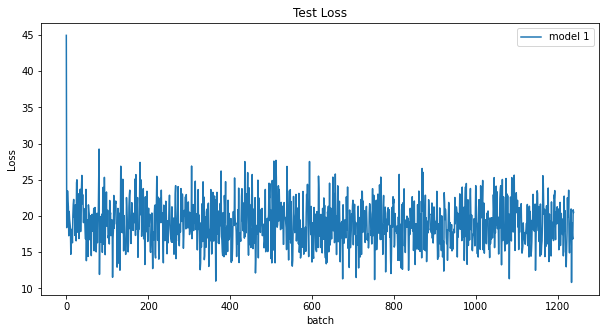


last 10 batch average RMSE = 18.19617105834299


In [16]:
# train loss를 plotting 하기 위한 코드#########
plt.figure(figsize=(10,5))
plt.title("Test Loss")
plt.plot(test_loss_record, label="model 1")
plt.xlabel("batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### <RMSE 평균값 구하는 곳 > (검색용) #######################################################
### 지금은 RMSE 평균값 계산할때, RMSE 값들을 가장 마지막 "10개" 배치만을 이용하도록 되어있음
### 
### RMSE 평균값 계산할때, RMSE 값들을 가장 마지막 "n개" 배치만을 이용하도록 하고 싶으면,
### 아래 코드에서 "-10" 부분을, "-n" 으로 숫자를 바꿔주면 된다. 
#############################################################################################
last_batch_avg_RMSE = sum(test_loss_record[-10:] ,0.0) / len(test_loss_record[-10:])
print("\nlast {} batch average RMSE = {}".format(-(-10) ,last_batch_avg_RMSE))